In this notebook we perform chemical identification from experimental images

Load packages and set random seeds

In [1]:
def morgan_fp_gen(smiles, nBits=2048):
    m1 = AllChem.MolFromSmiles(smiles)
    fp1 = AllChem.GetMorganFingerprintAsBitVect(m1,2,nBits=nBits)
    return np.array(fp1)

def load_jmol(path, dimension=[224,224], zoom=1):
    jmol_image = Image.open(path)

    # Determine the aspect ratio by finding the shorter dimension
    width, height = jmol_image.size
    min_dim = min(width, height)

    # Calculate the left, top, right, bottom coordinates for cropping
    left = (width - min_dim) / 2
    top = (height - min_dim) / 2
    right = (width + min_dim) / 2
    bottom = (height + min_dim) / 2

    # Crop the image to square
    jmol_image = jmol_image.crop((left, top, right, bottom))

    # Resize image to desired dimensions
    jmol_image = jmol_image.resize(dimension, resample=Image.Resampling.BILINEAR)

    # Apply zoom by cropping
    width, height = jmol_image.size
    left = width * ((1 - zoom) / 2)
    top = height * ((1 - zoom) / 2)
    right = width * ((1 + zoom) / 2)
    bottom = height * ((1 + zoom) / 2)
    jmol_image = jmol_image.crop((left, top, right, bottom))

    # Resize image to desired dimensions
    jmol_image = jmol_image.resize(dimension, resample=Image.Resampling.BILINEAR)

    # Convert to numpy array
    jmol_image_array = np.array(jmol_image)

    return jmol_image_array

def load_exp_img_stack(path, dimensions=[224,224], zoom=1, normalize=True, interpolation='bilinear'):
    '''Obtains stack of experimental images from folder path and preprocess 
        it so we can directly feed it to our CNN

        INPUT: path of the folder containing the AFM images of the molecule

        OUTPUT: list of PIL images'''
    path_list = sorted(glob.glob(os.path.join(path,'*')))
    im_list = list()
    for im_path in path_list:
        
        im_list.append(Image.open(im_path).resize(dimensions, resample=Image.Resampling.BILINEAR).convert('L'))
        
    # Default parameters
        degrees = 0
        h_shift = 0
        v_shift = 0
        shear = 0

        
    for i in range(len(im_list)):
        im_list[i] = TF.affine(im_list[i], degrees, [h_shift, v_shift], zoom, shear,
                                interpolation=transforms.InterpolationMode.BILINEAR,
                                fill=im_list[i].getpixel((5, 5))
                                )

    to_tensor = transforms.ToTensor()

    tensor_stack = [to_tensor(im) for im in im_list.copy()]
    tensor_stack = torch.cat(tensor_stack)

    #normalize = transforms.Normalize(
    #    mean=[0.1321, 0.1487, 0.1689, 0.1983, 0.2229, 0.2591, 0.3430, 0.4580, 0.5787, 0.6887],
    #    std=[0.0853, 0.0853, 0.0883, 0.0942, 0.0969, 0.1066, 0.1419, 0.1840, 0.2144, 0.2215]) #this is for K-1

    
    if normalize:

        normalize = transforms.Normalize(
            mean=[0.2855, 0.3973, 0.4424, 0.4134, 0.6759, 1.0664, 0.9904, 0.7708, 0.5748, 0.4055],
            std=[1.1341, 1.2528, 1.3125, 1.3561, 1.5844, 1.7763, 1.5447, 1.2683, 1.0588, 0.9308]) # for all K folders

        tensor_stack = normalize(tensor_stack)

    return tensor_stack

def load_exp_3_img(path, dimensions=[224,224], zoom=1):
    '''Obtains stack of experimental images from folder path and preprocess 
        it so we can directly feed it to our CNN

        INPUT: path of the folder containing the AFM images of the molecule

        OUTPUT: list of PIL images'''
    path_list = sorted(glob.glob(os.path.join(path,'*')))
    im_list = list()
    for im_index in [1,4,7]:
        
        im_list.append(Image.open(path_list[im_index]).resize(dimensions, resample=Image.Resampling.BILINEAR).convert('L'))
        
    # Default parameters
        degrees = 0
        h_shift = 0
        v_shift = 0
        shear = 0

        
    for i in range(len(im_list)):
        im_list[i] = TF.affine(im_list[i], degrees, [h_shift, v_shift], zoom, shear,
                                interpolation=transforms.InterpolationMode.BILINEAR,
                                fill=im_list[i].getpixel((5, 5))
                                )

    to_tensor = transforms.ToTensor()

    tensor_stack = [to_tensor(im) for im in im_list.copy()]
    tensor_stack = torch.cat(tensor_stack)

    normalize = transforms.Normalize(
        mean=[0.1487, 0.2229, 0.4580],
        std=[0.0853, 0.0969, 0.1840])
        

    tensor_stack = normalize(tensor_stack)

    return tensor_stack

def load_jmol_image(cid, dimension=[224,224], zoom=1):
    if USER=='manuel':
        path = f'/home/{USER}/QUAM-AFM/QUAM/JMOL_IMAGES/{cid}/{cid}.png' ##Mustang
    else:
        path = f'/scratch/dataset/quam/JMOL_IMAGES/{cid}/{cid}.png' ##Rocinante
    jmol_image = Image.open(path)
     # Resize image to desired dimensions
    jmol_image = jmol_image.resize(dimension, resample=Image.Resampling.BILINEAR)
    
    
    # Apply zoom by cropping
    width, height = jmol_image.size
    left = width * ((1 - zoom) / 2)
    top = height * ((1 - zoom) / 2)
    right = width * ((1 + zoom) / 2)
    bottom = height * ((1 + zoom) / 2)
    jmol_image = jmol_image.crop((left, top, right, bottom))
    
    # Resize image to desired dimensions
    jmol_image = jmol_image.resize(dimension, resample=Image.Resampling.BILINEAR)
    
    # Convert to numpy array
    jmol_image_array = np.array(jmol_image)
    
    return jmol_image_array

def _extract_cid(path):
    return int(path.split('_')[-3])

In [2]:
def load_exp_img_stack(path, dimensions=[224,224], zoom=1, normalize=True, interpolation='bilinear'):
    '''
    Obtains stack of experimental images from folder path and preprocesses 
    it so we can directly feed it to our CNN.

    Inputs:
    - path: Path of the folder containing the AFM images of the molecule.
    - dimensions: Desired dimensions for the output images. Default is [224,224].
    - zoom: Zoom level for the images. zoom <1 is zoom out and >1 zoom in. Default is 1.
    - normalize: If True, normalizes the output. Default is True.
    - interpolation: Interpolation method to be used. Options are 'bilinear', 'nearest', and 'bicubic'. 
                     Default is 'bilinear'.

    Output:
    - list of PIL images.
    '''
    interpolation_methods = {
        'bilinear': Image.Resampling.BILINEAR,
        'nearest': Image.Resampling.NEAREST,
        'bicubic': Image.Resampling.BICUBIC
    }

    torch_interpolation_methods = {
        'bilinear': transforms.InterpolationMode.BILINEAR,
        'nearest': transforms.InterpolationMode.NEAREST,
        'bicubic': transforms.InterpolationMode.BICUBIC
    }

    if interpolation not in interpolation_methods:
        raise ValueError(f'Interpolation method not recognized. Please use one of {list(interpolation_methods.keys())}.')

    path_list = sorted(glob.glob(os.path.join(path,'*')))
    im_list = list()
    for im_path in path_list:        
        im_list.append(Image.open(im_path).resize(dimensions, resample=interpolation_methods[interpolation]).convert('L'))
        
    # Default parameters
    degrees = 0
    h_shift = 0
    v_shift = 0
    shear = 0

    for i in range(len(im_list)):
        im_list[i] = TF.affine(im_list[i], degrees, [h_shift, v_shift], zoom, shear,
                                interpolation=torch_interpolation_methods[interpolation],
                                fill=im_list[i].getpixel((5, 5))
                                )

    to_tensor = transforms.ToTensor()

    tensor_stack = [to_tensor(im) for im in im_list.copy()]
    tensor_stack = torch.cat(tensor_stack)

    if normalize:
        normalize = transforms.Normalize(
            mean=[0.2855, 0.3973, 0.4424, 0.4134, 0.6759, 1.0664, 0.9904, 0.7708, 0.5748, 0.4055],
            std=[1.1341, 1.2528, 1.3125, 1.3561, 1.5844, 1.7763, 1.5447, 1.2683, 1.0588, 0.9308]) # for all K folders

        tensor_stack = normalize(tensor_stack)

    return tensor_stack



def rotate_image(image_array, angle, reshape=True, mode='nearest'):
    """
    Rotate a given numpy array image by the specified angle.

    Parameters:
    - image_array (numpy.ndarray): The input image array.
    - angle (float): The rotation angle in degrees.
    - reshape (bool): If True, the output shape will change. If False, the output shape is the same as the input.
    - mode (str): The mode parameter determines how the input array is extended when the filter overlaps a border.

    Returns:
    - numpy.ndarray: The rotated image array.
    """
    return rotate(image_array, angle, reshape=reshape, mode=mode)

In [2]:
!pip install rdkit


In [3]:
# IMPORTS
# additional packages
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import argparse
import os
import time
import glob
import numpy as np
from scipy.ndimage import rotate
from tqdm import tqdm
import scipy
import seaborn as sns
import rdkit.Chem.AllChem as AllChem
import sys
USER = os.getenv('USER')
sys.path.append(f'/home/{USER}/CODE/Pytorch-fingerprints/')
# torch packages
import torch
import torchvision
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.utils.data as data
from torch import optim
from torchvision import datasets, transforms, models
from torchvision.models import resnet50, ResNet50_Weights, efficientnet_b0, EfficientNet_B0_Weights
import torchvision.transforms.functional as TF

from torchmetrics import MetricCollection
from torchmetrics.classification import MultilabelRecall, MultilabelPrecision, MultilabelF1Score

import torch.nn.functional as F
from torch.utils.data import Dataset

print('PyTorch version:', torch.__version__)

# custom functions
from utils.all_utils import train_test_split, compute_pos_weights, save_config, train_for_epoch, validate, \
                            balance_beta_pos_weights, tanimoto_torch, validate_tanimoto

from utils.models import ResNet3D, resnet_10_chan, effnet_10_chan, eff_net_bias_warmer, resnet_bias_warmer 

from utils.dataloader import QUAM

from utils.screening import fp_screening_function, load_img_stack, predict_fp, tanimoto_numpy





print('Packages loaded')


class configuration:
    def __init__(self):
        # EXPERIMENT PARAMETERS
        self.experiment_name = 'exp_imgs'
        self.n_fp = 1024  # number of fingerprints
        self.output_size = 10
        self.ratio = 0.95  # train/test ratio
        self.seed = 42

        # TRAINING PARAMETERS

        self.lr = 0.001  # learning rate
        self.dropout = 0.5 # Dropout2d probability
        # self.momentum = 0.9  # momentum of SGD optimizer
        self.weight_decay = 0  # L2 regularization constant
        self.batch_size = 50  # Training batch size
        self.test_batch_size = 50  # Test batch size
        self.epochs = 150  # Number of epochs
        self.bias_warmer = True # setting appropiate bias
        self.pos_weight_balancer = True #for bigger fingerprints, it helps balance precision and recall
        self.pos_weight_beta = 10
        # DATA AUGMENTATION PARAMETERS

        # Rotation
        self.rot_prob = 0.5  # prob of rotation in data augmentation
        self.max_deg = 180  # maximum degrees of rotation in data augmentation

        # Zoom
        self.zoom_prob = 0.3  # prob of applying zoom
        self.max_zoom = 0.3  # maximum zooming in/out

        # Translation
        self.shift_prob = 0.3  # probability of vertical or/and horizontal translation
        self.max_shift = 20  # translation

        # Shear
        self.shear_prob = 0.3  # probability of shearing
        self.max_shear = 10  # maximum shearing angle

## Create arguments object
args = configuration()
# Print experiment name
print('Experiment name:', args.experiment_name)


# make sure to enable GPU acceleration!
print(f'available devices: {torch.cuda.device_count()}')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#torch.cuda.device(0)
#device = torch.device('cpu')
#print(device, torch.cuda.get_device_name(0))

# Set random seed for reproducibility
torch.backends.cudnn.deterministic = True  # fix the GPU to deterministic mode
torch.manual_seed(args.seed)  # CPU seed
torch.cuda.manual_seed_all(args.seed)  # GPU seed
random.seed(args.seed)  # python seed for image transformation
np.random.seed(args.seed)



/home/mgonzalez/.conda/envs/pytorch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/mgonzalez/.conda/envs/pytorch/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


PyTorch version: 2.2.1+cu121
Packages loaded
Experiment name: exp_imgs
available devices: 0


/home/mgonzalez/.conda/envs/pytorch/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Load data

In [4]:
# Load data
data_path = f'/home/{USER}/QUAM-AFM/datasets/285k_train_15k_val_test_1024bits_df.gz'
dataset_df = pd.read_pickle(data_path)

train_df = dataset_df[dataset_df['split'] == 'train']
test_df = dataset_df[dataset_df['split'] == 'test']

trainset = QUAM(args, train_df, mode='train')
train_loader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, num_workers=1,
                                           pin_memory=True)
print('Train set samples:', len(trainset))

testset = QUAM(args, test_df.dropna(), mode='test') #dropna for the experimental molecule
test_loader = torch.utils.data.DataLoader(testset, batch_size=args.test_batch_size, shuffle=False, num_workers=1,
                                          pin_memory=True)

print('Test set samples:', len(testset))

Train set samples: 285000
Test set samples: 279905


Load model checkpoint

In [5]:
# FOR GPU

# model and metrics initialization

# model = ResNet3D(output_size=args.n_fp)
model = effnet_10_chan(output_size=args.n_fp, dropout=args.dropout)


models_path = f'/home/{USER}/CODE/Pytorch-fingerprints/experiments/300k_1024_all_ks_dropout_0_5/models'
checkpoint = torch.load(os.path.join(models_path, 'checkpoint_5_virtual_epoch_7.pth'))

model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [5]:
# FOR CPU
# model and metrics initialization

# model = ResNet3D(output_size=args.n_fp)
model = effnet_10_chan(output_size=args.n_fp, dropout=args.dropout)


models_path = f'/home/{USER}/CODE/Pytorch-fingerprints/experiments/300k_1024_all_ks_dropout_0_5/models'
checkpoint = torch.load(os.path.join(models_path, 'checkpoint_5_virtual_epoch_7.pth'), map_location=torch.device('cpu'))

model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(10, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): Dropout2d(p=0.5, inplace=False)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivation(
            (0): Conv2d(32, 16, kernel_siz

## Try experimental images


### 2-iodotriphenylene

In [6]:
sample_df = test_df

In [7]:
path = f'/home/{USER}/EXPERIMENTAL_IMAGES/RAW/2-Iodotriphenylene_88955426'
sorted(glob.glob(os.path.join(path,'*')))

['/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2-Iodotriphenylene_88955426/z058_1.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2-Iodotriphenylene_88955426/z066_2.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2-Iodotriphenylene_88955426/z074_3.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2-Iodotriphenylene_88955426/z082_4.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2-Iodotriphenylene_88955426/z090_5.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2-Iodotriphenylene_88955426/z098_6.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2-Iodotriphenylene_88955426/z106_7.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2-Iodotriphenylene_88955426/z114_8.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2-Iodotriphenylene_88955426/z122_9.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2-Iodotriphenylene_88955426/z130_10.jpg']

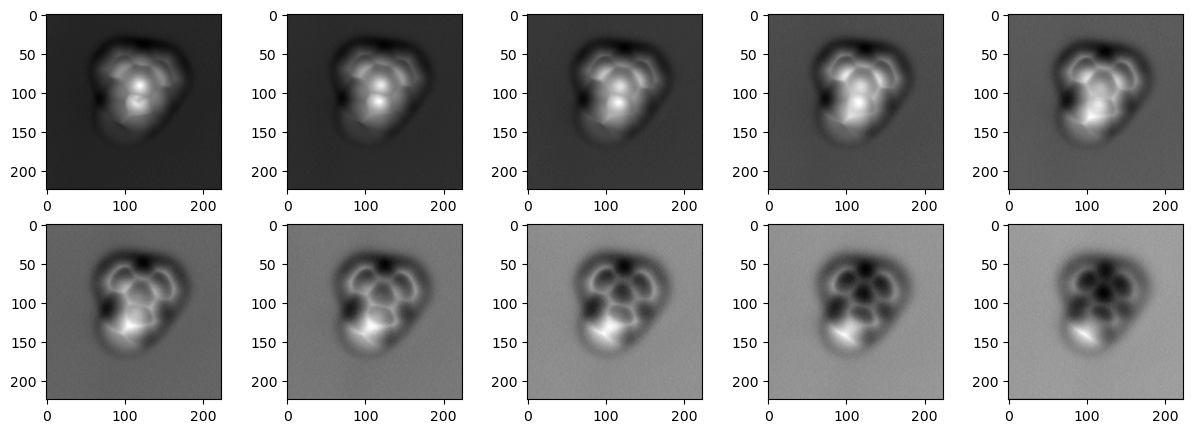

In [8]:
exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=1)
#10 images
f, axarr = plt.subplots(2,5, figsize=(15, 5))
axarr[0,0].imshow(exp_img[0], cmap = 'gray')
axarr[0,1].imshow(exp_img[1], cmap = 'gray')
axarr[0,2].imshow(exp_img[2], cmap = 'gray')
axarr[0,3].imshow(exp_img[3], cmap = 'gray')
axarr[0,4].imshow(exp_img[4], cmap = 'gray')
axarr[1,0].imshow(exp_img[5], cmap = 'gray')
axarr[1,1].imshow(exp_img[6], cmap = 'gray')
axarr[1,2].imshow(exp_img[7], cmap = 'gray')
axarr[1,3].imshow(exp_img[8], cmap = 'gray')
axarr[1,4].imshow(exp_img[9], cmap = 'gray')

In [106]:
#the CID was in neither train nor test so we added it, now it is here.

In [10]:

CID = 88955426
SMILES = 'C1=CC=C2C(=C1)C3=C(C=C(C=C3)I)C4=CC=CC=C24'
morgan_fp = morgan_fp_gen(SMILES, nBits=1024)
split='test'
corrugation = np.nan



experimental_df = sample_df.append({'path':path,
                           'CID':CID, 
                           'SMILES':SMILES,
                           'morgan_fp':morgan_fp,
                           'split':split,
                           'corrugation':corrugation
                            }, ignore_index=True)
experimental_df

/tmp/ipykernel_246366/1047229894.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  experimental_df = sample_df.append({'path':path,


path        CID  \
0       /scratch/dataset/quam/K-1/Conformer3D_CID_1000...   10001048   
1       /scratch/dataset/quam/K-1/Conformer3D_CID_1000...      10005   
2       /scratch/dataset/quam/K-1/Conformer3D_CID_1001...  100128716   
3       /scratch/dataset/quam/K-1/Conformer3D_CID_1001...  100175925   
4       /scratch/dataset/quam/K-1/Conformer3D_CID_1001...  100197007   
...                                                   ...        ...   
279901  /scratch/dataset/quam/K-1/Conformer3D_CID_3410...     341027   
279902  /scratch/dataset/quam/K-1/Conformer3D_CID_5392...   53921077   
279903  /scratch/dataset/quam/K-1/Conformer3D_CID_8238...   82382131   
279904  /scratch/dataset/quam/K-1/Conformer3D_CID_8241...   82418146   
279905  /home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2-Iodo...   88955426   

                                                   SMILES  \
0       C1=CC=C2C=C3C(=CC2=C1)NC(=N3)C4=CC5=C(C=C4)N=C...   
1                                            C(#N)N=C(N)N   
2                       CC1=C(C2=NC(=CC(=C2C=C1)NCCCN)C)C   
3                     COC(=O)CSC1=NN=C(S1)NC(=O)C2=CC=CO2   
4       COC(=O)CSC1=NN=C(S1)NC(=O)C2=CC3=C(O2)C=CC4=CC...   
...                                                   ...   
279901               C1OC2=C(O1)C(=O)C3=C(C2=O)C=CC(=C3)O   
279902                                  C1=CC(=CC=C1C=N)N   
279903            CC1=C2C=C(NC2=CC=C1)C3=NN=CC(=C3)C(=O)O   
279904                             C1=C(N=C(O1)C=O)C(=O)O   
279905         C1=CC=C2C(=C1)C3=C(C=C(C=C3)I)C4=CC=CC=C24   

                                                morgan_fp split  corrugation  
0       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       1.1767  
1       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0002  
2       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0110  
3       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0530  
4       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0856  
...                                                   ...   ...          ...  
279901  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0035  
279902  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0008  
279903  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0034  
279904  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0057  
279905  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test          NaN  

[279906 rows x 6 columns]

In [11]:
experimental_df[experimental_df['path'] == path]

path       CID  \
279905  /home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2-Iodo...  88955426   

                                            SMILES  \
279905  C1=CC=C2C(=C1)C3=C(C=C(C=C3)I)C4=CC=CC=C24   

                                                morgan_fp split  corrugation  
279905  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test          NaN

In [12]:

exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=0.9, interpolation='bicubic')
with torch.no_grad():
    batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
    print(batched_tensor.size())
    predictions = model(batched_tensor)
    print(predictions.size())
    fp_pred = (torch.sigmoid(predictions) > 0.5)
    print(fp_pred.size())

exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()
print(exp_fp.shape)
print(exp_fp.sum())

torch.Size([1, 10, 224, 224])
torch.Size([1, 1024])
torch.Size([1, 1024])
(1024,)
21


In [13]:
output_df = fp_screening_function(exp_fp, experimental_df, top_k = 20)

print('Is the correct CID in the top k candidates?',  CID in list(output_df['CID']))
output_df

Is the correct CID in the top k candidates? True


path        CID  \
279905  /home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2-Iodo...   88955426   
132955  /scratch/dataset/quam/K-1/Conformer3D_CID_1304...  130412167   
154541  /scratch/dataset/quam/K-1/Conformer3D_CID_1320...  132093176   
190497  /scratch/dataset/quam/K-1/Conformer3D_CID_8885...   88850427   
187699  /scratch/dataset/quam/K-1/Conformer3D_CID_1351...  135172310   
166588  /scratch/dataset/quam/K-1/Conformer3D_CID_8615...   86150547   
196977  /scratch/dataset/quam/K-1/Conformer3D_CID_3678...    3678069   
247370  /scratch/dataset/quam/K-1/Conformer3D_CID_2233...     223327   
187596  /scratch/dataset/quam/K-1/Conformer3D_CID_1351...  135172291   
247596  /scratch/dataset/quam/K-1/Conformer3D_CID_2303...   23035875   
198037  /scratch/dataset/quam/K-1/Conformer3D_CID_1342...  134242638   
188622  /scratch/dataset/quam/K-1/Conformer3D_CID_1265...  126540386   
190539  /scratch/dataset/quam/K-1/Conformer3D_CID_1266...  126688093   
247665  /scratch/dataset/quam/K-1/Conformer3D_CID_2303...   23035871   
139669  /scratch/dataset/quam/K-1/Conformer3D_CID_7157...   71575300   
190547  /scratch/dataset/quam/K-1/Conformer3D_CID_1373...  137394819   
11355   /scratch/dataset/quam/K-1/Conformer3D_CID_1299...   12996280   
279463  /scratch/dataset/quam/K-1/Conformer3D_CID_1360...     136038   
168975  /scratch/dataset/quam/K-1/Conformer3D_CID_4145...    4145562   
116642  /scratch/dataset/quam/K-1/Conformer3D_CID_1085...   10857255   

                                                   SMILES  \
279905         C1=CC=C2C(=C1)C3=C(C=C(C=C3)I)C4=CC=CC=C24   
132955      C1=CC=C2C(=C1)C3=C(C=CC(=C3)I)C4=C2C=C(C=C4)I   
154541           C1=CC=C2C(=C1)C=CC3=C2C=CC4=C3C=C(C=C4)I   
190497         C1=CC=C2C(=C1)C3=C(C=C(C=C3)I)C4=NC=CN=C24   
187699      C1=CC=C2C3=C(C4=C(C2=C1)C=CC(=C4)I)N=C(C=C3)I   
166588                   C1=CC=C2C(=C1)C3=C(S2)C=C(C=C3)I   
196977                   C1=CC=C2C(=C1)C3=C(N2)C=CC(=C3)I   
247370                   C1=CC=C2C(=C1)C3=C(O2)C=CC(=C3)I   
187596        C1=CC=C2C(=C1)C3=C(C=C(C=C3)I)N4C2=CC(=N4)I   
247596                   COC1=C2C=CC(=CC2=CC3=CC=CC=C31)I   
198037                  C1=CC=C2C(=C1)C3=C(N2N)C=C(C=C3)I   
188622                      CN1C2=CC=CC=C2C3=C1C=C(C=C3)I   
190539                  C1=CC=C2C(=C1)C3=C(N2I)C=CC(=C3)I   
247665                  C1=CC=C2C(=C1)C=C3C=C(C=CC3=C2O)I   
139669                   COC1=C2C=CC(=CC2=NC3=CC=CC=C31)I   
190547      C1=CC=C2C(=C1)C3=C4N2C5=C(C4=CC=C3)C=CC(=C5)I   
11355   C1=CC=C2C(=C1)C3=C2C4=C(C=C3)C5=CC6=C7C=CC8=C(...   
279463  C1=CC=C2C(=C1)C3=CC=CC=C3C4=CC5=CC6=C(C=C5C=C2...   
168975                C1=CC=C2C(=C1)C3=CC=CC=C3C(=C2Br)Br   
116642                                  C=CC1=CC(=CC=C1)I   

                                                morgan_fp split  corrugation  \
279905  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test          NaN   
132955  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0025   
154541  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0008   
190497  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0012   
187699  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0011   
166588  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0008   
196977  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0002   
247370  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0015   
187596  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0036   
247596  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       1.1890   
198037  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...  test       0.0012   
188622  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0015   
190539  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0036   
247665  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0019   
139669  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 

In [14]:
gt_fp = morgan_fp
tanimoto_numpy(exp_fp.squeeze(), gt_fp)

0.8095238095238095

In [15]:
len(experimental_df)

279906

In [16]:
for interpolation_method in ['bilinear', 'nearest', 'bicubic']:
    print(f'Interpolation method: {interpolation_method}')
    for zoom in [ 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]:
        exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=zoom, interpolation=interpolation_method)
        with torch.no_grad():
            batched_tensor = exp_img.unsqueeze(dim = 0).to(device)

            predictions = model(batched_tensor)

            fp_pred = (torch.sigmoid(predictions) > 0.5)


        exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()

        gt_fp = morgan_fp
        
        print('zoom:', zoom, 'tanimoto', round(tanimoto_numpy(exp_fp.squeeze(), gt_fp), 2))


Interpolation method: bilinear
zoom: 0.5 tanimoto 0.37
zoom: 0.6 tanimoto 0.39
zoom: 0.7 tanimoto 0.48
zoom: 0.8 tanimoto 0.44
zoom: 0.9 tanimoto 0.85
zoom: 1 tanimoto 0.44
zoom: 1.1 tanimoto 0.52
zoom: 1.2 tanimoto 0.52
zoom: 1.3 tanimoto 0.36
zoom: 1.4 tanimoto 0.25
zoom: 1.5 tanimoto 0.3
Interpolation method: nearest
zoom: 0.5 tanimoto 0.28
zoom: 0.6 tanimoto 0.39
zoom: 0.7 tanimoto 0.41
zoom: 0.8 tanimoto 0.39
zoom: 0.9 tanimoto 0.54
zoom: 1 tanimoto 0.43
zoom: 1.1 tanimoto 0.5
zoom: 1.2 tanimoto 0.42
zoom: 1.3 tanimoto 0.36
zoom: 1.4 tanimoto 0.27
zoom: 1.5 tanimoto 0.27
Interpolation method: bicubic
zoom: 0.5 tanimoto 0.37
zoom: 0.6 tanimoto 0.39
zoom: 0.7 tanimoto 0.42
zoom: 0.8 tanimoto 0.44
zoom: 0.9 tanimoto 0.81
zoom: 1 tanimoto 0.44
zoom: 1.1 tanimoto 0.52
zoom: 1.2 tanimoto 0.67
zoom: 1.3 tanimoto 0.36
zoom: 1.4 tanimoto 0.24
zoom: 1.5 tanimoto 0.29


### BCB: 1-Bromo-3,5-dichlorobenzene
https://pubchem.ncbi.nlm.nih.gov/compound/29766

In [17]:
path = f'/home/{USER}/EXPERIMENTAL_IMAGES/RAW/1-Bromo-3,5-dichlorobenzene' 

sample_df = test_df
sorted(glob.glob(os.path.join(path,'*')))

['/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/1-Bromo-3,5-dichlorobenzene/image_0.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/1-Bromo-3,5-dichlorobenzene/image_1.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/1-Bromo-3,5-dichlorobenzene/image_2.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/1-Bromo-3,5-dichlorobenzene/image_3.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/1-Bromo-3,5-dichlorobenzene/image_4.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/1-Bromo-3,5-dichlorobenzene/image_5.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/1-Bromo-3,5-dichlorobenzene/image_6.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/1-Bromo-3,5-dichlorobenzene/image_7.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/1-Bromo-3,5-dichlorobenzene/image_8.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/1-Bromo-3,5-dichlorobenzene/image_9.jpg']

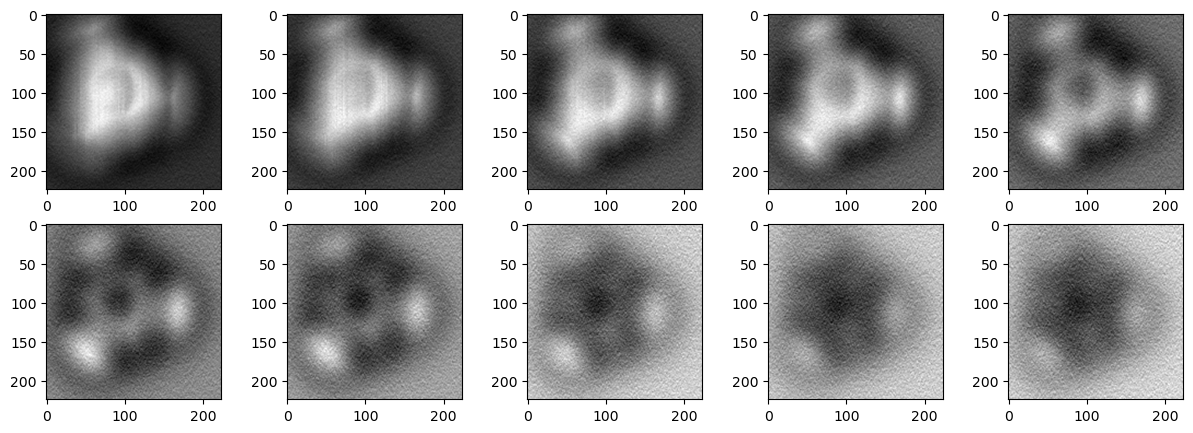

In [18]:
exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=1.4, normalize=True, interpolation='bicubic')

#10 images
f, axarr = plt.subplots(2,5, figsize=(15, 5))
axarr[0,0].imshow(exp_img[0], cmap = 'gray')
axarr[0,1].imshow(exp_img[1], cmap = 'gray')
axarr[0,2].imshow(exp_img[2], cmap = 'gray')
axarr[0,3].imshow(exp_img[3], cmap = 'gray')
axarr[0,4].imshow(exp_img[4], cmap = 'gray')
axarr[1,0].imshow(exp_img[5], cmap = 'gray')
axarr[1,1].imshow(exp_img[6], cmap = 'gray')
axarr[1,2].imshow(exp_img[7], cmap = 'gray')
axarr[1,3].imshow(exp_img[8], cmap = 'gray')
axarr[1,4].imshow(exp_img[9], cmap = 'gray')

In [19]:
CID = 29766
SMILES = 'C1=C(C=C(C=C1Cl)Br)Cl'
morgan_fp = morgan_fp_gen(SMILES, nBits=1024)
split='test'
corrugation = np.nan



experimental_df = sample_df.append({'path':path,
                           'CID':CID, 
                           'SMILES':SMILES,
                           'morgan_fp':morgan_fp,
                           'split':split,
                           'corrugation':corrugation
                            }, ignore_index=True)
experimental_df

/tmp/ipykernel_246366/1308444949.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  experimental_df = sample_df.append({'path':path,


path        CID  \
0       /scratch/dataset/quam/K-1/Conformer3D_CID_1000...   10001048   
1       /scratch/dataset/quam/K-1/Conformer3D_CID_1000...      10005   
2       /scratch/dataset/quam/K-1/Conformer3D_CID_1001...  100128716   
3       /scratch/dataset/quam/K-1/Conformer3D_CID_1001...  100175925   
4       /scratch/dataset/quam/K-1/Conformer3D_CID_1001...  100197007   
...                                                   ...        ...   
279901  /scratch/dataset/quam/K-1/Conformer3D_CID_3410...     341027   
279902  /scratch/dataset/quam/K-1/Conformer3D_CID_5392...   53921077   
279903  /scratch/dataset/quam/K-1/Conformer3D_CID_8238...   82382131   
279904  /scratch/dataset/quam/K-1/Conformer3D_CID_8241...   82418146   
279905  /home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/1-Brom...      29766   

                                                   SMILES  \
0       C1=CC=C2C=C3C(=CC2=C1)NC(=N3)C4=CC5=C(C=C4)N=C...   
1                                            C(#N)N=C(N)N   
2                       CC1=C(C2=NC(=CC(=C2C=C1)NCCCN)C)C   
3                     COC(=O)CSC1=NN=C(S1)NC(=O)C2=CC=CO2   
4       COC(=O)CSC1=NN=C(S1)NC(=O)C2=CC3=C(O2)C=CC4=CC...   
...                                                   ...   
279901               C1OC2=C(O1)C(=O)C3=C(C2=O)C=CC(=C3)O   
279902                                  C1=CC(=CC=C1C=N)N   
279903            CC1=C2C=C(NC2=CC=C1)C3=NN=CC(=C3)C(=O)O   
279904                             C1=C(N=C(O1)C=O)C(=O)O   
279905                              C1=C(C=C(C=C1Cl)Br)Cl   

                                                morgan_fp split  corrugation  
0       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       1.1767  
1       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0002  
2       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0110  
3       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0530  
4       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0856  
...                                                   ...   ...          ...  
279901  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0035  
279902  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0008  
279903  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0034  
279904  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0057  
279905  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test          NaN  

[279906 rows x 6 columns]

In [20]:
experimental_df[experimental_df['path'] == path]



path    CID  \
279905  /home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/1-Brom...  29766   

                       SMILES  \
279905  C1=C(C=C(C=C1Cl)Br)Cl   

                                                morgan_fp split  corrugation  
279905  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test          NaN

In [21]:
arr = list(experimental_df[experimental_df['path'] == path]['morgan_fp'])[0]
arr.sum()

13

In [22]:

exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=1.4, normalize=True)
with torch.no_grad():
    batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
    print(batched_tensor.size())
    predictions = model(batched_tensor)
    print(predictions.size())
    fp_pred = (torch.sigmoid(predictions) > 0.5)
    print(fp_pred.size())

exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()
print(exp_fp.shape)
print(exp_fp.sum())

torch.Size([1, 10, 224, 224])
torch.Size([1, 1024])
torch.Size([1, 1024])
(1024,)
13


In [23]:
fp_pred = (torch.sigmoid(predictions) > 0.5)
exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()
print(exp_fp.sum())

13


In [24]:
output_df = fp_screening_function(exp_fp, experimental_df, top_k = 20)

print('Is the correct CID in the top k candidates?',  CID in list(output_df['CID']))
output_df

Is the correct CID in the top k candidates? True


path        CID  \
279905  /home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/1-Brom...      29766   
163425  /scratch/dataset/quam/K-1/Conformer3D_CID_2976...      29766   
164285  /scratch/dataset/quam/K-1/Conformer3D_CID_8467...      84676   
158018  /scratch/dataset/quam/K-1/Conformer3D_CID_2334...   23341361   
240294  /scratch/dataset/quam/K-1/Conformer3D_CID_1180...  118085432   
238652  /scratch/dataset/quam/K-1/Conformer3D_CID_5842...   58424182   
241830  /scratch/dataset/quam/K-1/Conformer3D_CID_1079...  107954577   
270319  /scratch/dataset/quam/K-1/Conformer3D_CID_3312...      33128   
278890  /scratch/dataset/quam/K-1/Conformer3D_CID_7928...       7928   
231766  /scratch/dataset/quam/K-1/Conformer3D_CID_1308...  130802465   
172023  /scratch/dataset/quam/K-1/Conformer3D_CID_1053...  105360388   
278479  /scratch/dataset/quam/K-1/Conformer3D_CID_3640...      36400   
240585  /scratch/dataset/quam/K-1/Conformer3D_CID_6062...     606256   
269900  /scratch/dataset/quam/K-1/Conformer3D_CID_2212...   22121455   
127967  /scratch/dataset/quam/K-1/Conformer3D_CID_1227...      12279   
162528  /scratch/dataset/quam/K-1/Conformer3D_CID_6411...     641155   
266355  /scratch/dataset/quam/K-1/Conformer3D_CID_1079...  107944554   
266254  /scratch/dataset/quam/K-1/Conformer3D_CID_5099...   50997989   
179430  /scratch/dataset/quam/K-1/Conformer3D_CID_1079...  107940718   
265933  /scratch/dataset/quam/K-1/Conformer3D_CID_1079...  107940949   

                                        SMILES  \
279905                   C1=C(C=C(C=C1Cl)Br)Cl   
163425                   C1=C(C=C(C=C1Cl)Br)Cl   
164285                   C1=C(C=C(C=C1Br)Br)Cl   
158018  C1=C(C=C(C=C1Cl)Cl)C2=CC(=CC(=C2)Br)Br   
240294                CN(C)C1=CC(=CC(=C1)Br)Cl   
238652            [C-]#[N+]C1=CC(=CC(=C1)Br)Cl   
241830               C1=C(C=C(C=C1Cl)Br)C#CC#N   
270319               C1=C(C=C(C=C1Cl)Br)C(=O)O   
278890                     C1=CC(=CC(=C1)Br)Cl   
231766            C1=C(C=C(C=C1Cl)Br)C2=NNN=C2   
172023              C1=C(C=C(C=C1Cl)Br)C(=O)NO   
278479  C1=C(C=C(C=C1Cl)Cl)C2=CC(=CC(=C2)Cl)Cl   
240585                       C1=C(C=NC=C1Br)Cl   
269900             C1=C(C=C(C=C1Cl)Br)C(=O)CBr   
127967                   C1=C(C=C(C=C1Br)Br)Br   
162528                  CC1=C(C=C(C=C1Cl)Br)Cl   
266355             C#CC(=O)C1=CC(=CC(=C1)Br)Cl   
266254              COC(=O)C1=CC(=CC(=C1)Br)Cl   
179430        C1=C(C=C(C=C1Cl)Br)C2=NC(=NO2)Cl   
265933        C1=C(C=C(C=C1Cl)Br)C2=NN=C(S2)Cl   

                                                morgan_fp split  corrugation  \
279905  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test          NaN   
163425  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0004   
164285  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0013   
158018  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       1.4552   
240294  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0070   
238652  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0015   
241830  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0014   
270319  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0013   
278890  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0006   
231766  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.9886   
172023  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.9306   
278479  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       1.4000   
240585  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0011   
269900  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0829   
127967  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0002   
162528  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0019   
266355  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0007   
266254  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [25]:
gt_fp = morgan_fp
tanimoto_numpy(exp_fp.squeeze(), gt_fp)

0.8571428571428571

In [26]:
for interpolation_method in ['bilinear', 'nearest', 'bicubic']:
    print(f'Interpolation method: {interpolation_method}')
    for zoom in [ 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]:
        exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=zoom, interpolation=interpolation_method)
        with torch.no_grad():
            batched_tensor = exp_img.unsqueeze(dim = 0).to(device)

            predictions = model(batched_tensor)

            fp_pred = (torch.sigmoid(predictions) > 0.5)


        exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()

        gt_fp = morgan_fp
        
        print('zoom:', zoom, 'tanimoto', round(tanimoto_numpy(exp_fp.squeeze(), gt_fp), 2))

Interpolation method: bilinear
zoom: 0.5 tanimoto 0.3
zoom: 0.6 tanimoto 0.29
zoom: 0.7 tanimoto 0.33
zoom: 0.8 tanimoto 0.23
zoom: 0.9 tanimoto 0.2
zoom: 1 tanimoto 0.17
zoom: 1.1 tanimoto 0.15
zoom: 1.2 tanimoto 0.5
zoom: 1.3 tanimoto 0.72
zoom: 1.4 tanimoto 0.86
zoom: 1.5 tanimoto 0.35
Interpolation method: nearest
zoom: 0.5 tanimoto 0.16
zoom: 0.6 tanimoto 0.5
zoom: 0.7 tanimoto 0.43
zoom: 0.8 tanimoto 0.5
zoom: 0.9 tanimoto 0.5
zoom: 1 tanimoto 0.62
zoom: 1.1 tanimoto 0.0
zoom: 1.2 tanimoto 0.0
zoom: 1.3 tanimoto 0.0
zoom: 1.4 tanimoto 0.0
zoom: 1.5 tanimoto 0.0
Interpolation method: bicubic
zoom: 0.5 tanimoto 0.26
zoom: 0.6 tanimoto 0.3
zoom: 0.7 tanimoto 0.27
zoom: 0.8 tanimoto 0.22
zoom: 0.9 tanimoto 0.18
zoom: 1 tanimoto 0.21
zoom: 1.1 tanimoto 0.33
zoom: 1.2 tanimoto 0.53
zoom: 1.3 tanimoto 0.62
zoom: 1.4 tanimoto 0.43
zoom: 1.5 tanimoto 0.05


### PTCDA: 3,4,9,10-Perylenetetracarboxylic dianhydride
https://pubchem.ncbi.nlm.nih.gov/compound/67191

In [27]:
path = f'/home/{USER}/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA' 
sample_df = test_df
sorted(glob.glob(os.path.join(path,'*')))

['/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA/image_0.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA/image_1.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA/image_2.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA/image_3.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA/image_4.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA/image_5.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA/image_6.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA/image_7.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA/image_8.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA/image_9.jpg']

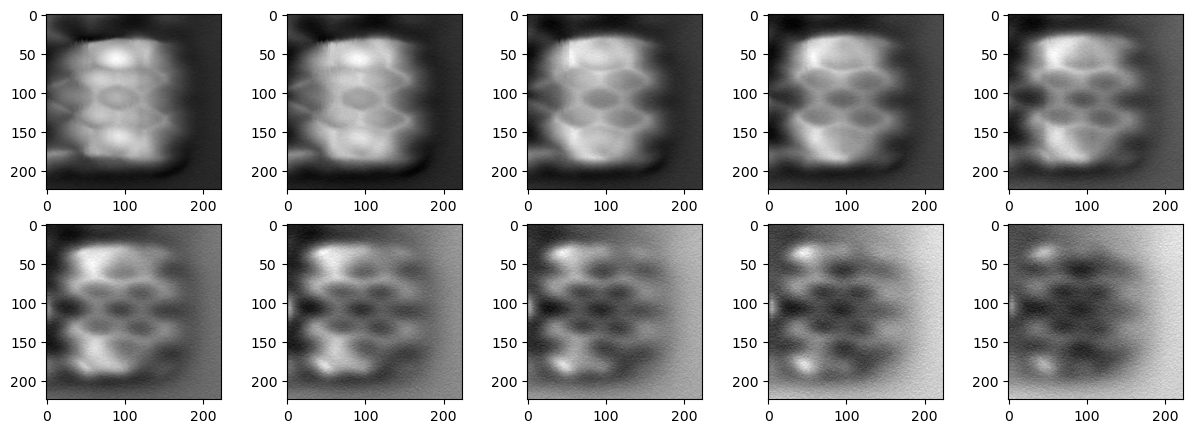

In [28]:
exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=1, normalize=True)

#10 images
f, axarr = plt.subplots(2,5, figsize=(15, 5))
axarr[0,0].imshow(exp_img[0], cmap = 'gray')
axarr[0,1].imshow(exp_img[1], cmap = 'gray')
axarr[0,2].imshow(exp_img[2], cmap = 'gray')
axarr[0,3].imshow(exp_img[3], cmap = 'gray')
axarr[0,4].imshow(exp_img[4], cmap = 'gray')
axarr[1,0].imshow(exp_img[5], cmap = 'gray')
axarr[1,1].imshow(exp_img[6], cmap = 'gray')
axarr[1,2].imshow(exp_img[7], cmap = 'gray')
axarr[1,3].imshow(exp_img[8], cmap = 'gray')
axarr[1,4].imshow(exp_img[9], cmap = 'gray')

In [29]:
CID = 67191
SMILES = 'C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C(=O)OC7=O)C(=O)OC2=O'
morgan_fp = morgan_fp_gen(SMILES, nBits=1024)
split='test'
corrugation = np.nan



experimental_df = sample_df.append({'path':path,
                           'CID':CID, 
                           'SMILES':SMILES,
                           'morgan_fp':morgan_fp,
                           'split':split,
                           'corrugation':corrugation
                            }, ignore_index=True)
experimental_df

/tmp/ipykernel_246366/416637777.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  experimental_df = sample_df.append({'path':path,


path        CID  \
0       /scratch/dataset/quam/K-1/Conformer3D_CID_1000...   10001048   
1       /scratch/dataset/quam/K-1/Conformer3D_CID_1000...      10005   
2       /scratch/dataset/quam/K-1/Conformer3D_CID_1001...  100128716   
3       /scratch/dataset/quam/K-1/Conformer3D_CID_1001...  100175925   
4       /scratch/dataset/quam/K-1/Conformer3D_CID_1001...  100197007   
...                                                   ...        ...   
279901  /scratch/dataset/quam/K-1/Conformer3D_CID_3410...     341027   
279902  /scratch/dataset/quam/K-1/Conformer3D_CID_5392...   53921077   
279903  /scratch/dataset/quam/K-1/Conformer3D_CID_8238...   82382131   
279904  /scratch/dataset/quam/K-1/Conformer3D_CID_8241...   82418146   
279905  /home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/Peryle...      67191   

                                                   SMILES  \
0       C1=CC=C2C=C3C(=CC2=C1)NC(=N3)C4=CC5=C(C=C4)N=C...   
1                                            C(#N)N=C(N)N   
2                       CC1=C(C2=NC(=CC(=C2C=C1)NCCCN)C)C   
3                     COC(=O)CSC1=NN=C(S1)NC(=O)C2=CC=CO2   
4       COC(=O)CSC1=NN=C(S1)NC(=O)C2=CC3=C(O2)C=CC4=CC...   
...                                                   ...   
279901               C1OC2=C(O1)C(=O)C3=C(C2=O)C=CC(=C3)O   
279902                                  C1=CC(=CC=C1C=N)N   
279903            CC1=C2C=C(NC2=CC=C1)C3=NN=CC(=C3)C(=O)O   
279904                             C1=C(N=C(O1)C=O)C(=O)O   
279905  C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C...   

                                                morgan_fp split  corrugation  
0       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       1.1767  
1       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0002  
2       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0110  
3       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0530  
4       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0856  
...                                                   ...   ...          ...  
279901  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0035  
279902  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0008  
279903  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0034  
279904  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0057  
279905  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test          NaN  

[279906 rows x 6 columns]

In [30]:
experimental_df[experimental_df['path'] == path]



path    CID  \
279905  /home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/Peryle...  67191   

                                                   SMILES  \
279905  C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C...   

                                                morgan_fp split  corrugation  
279905  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test          NaN

In [31]:
arr = list(experimental_df[experimental_df['path'] == path]['morgan_fp'])[0]
arr.sum()

18

In [32]:

exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=1, normalize=True)
with torch.no_grad():
    batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
    print(batched_tensor.size())
    predictions = model(batched_tensor)
    print(predictions.size())
    fp_pred = (torch.sigmoid(predictions) > 0.5)
    print(fp_pred.size())

exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()
print(exp_fp.shape)
print(exp_fp.sum())

torch.Size([1, 10, 224, 224])
torch.Size([1, 1024])
torch.Size([1, 1024])
(1024,)
18


In [33]:
fp_pred = (torch.sigmoid(predictions) > 0.5)
exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()
print(exp_fp.sum())

18


In [34]:
output_df = fp_screening_function(exp_fp, experimental_df, top_k = 5)

print('Is the correct CID in the top k candidates?',  CID in list(output_df['CID']))
output_df

Is the correct CID in the top k candidates? True


path        CID  \
279905  /home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/Peryle...      67191   
103812  /scratch/dataset/quam/K-1/Conformer3D_CID_5946...   59464606   
1245    /scratch/dataset/quam/K-1/Conformer3D_CID_1374...  137432859   
133912  /scratch/dataset/quam/K-1/Conformer3D_CID_1124...   11249724   
70616   /scratch/dataset/quam/K-1/Conformer3D_CID_7965...      79657   

                                                   SMILES  \
279905  C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C...   
103812  C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C...   
1245    C1=CC=C2C(=C1)C3=C(C4=C(C=C3)C5=CC=CC=C5C4=O)C...   
133912  CN1C(=O)C2=C3C(=CC=C4C3=C(C=C2)C5=C6C4=CC=C7C6...   
70616   CN1C(=O)C2=C3C(=CC=C4C3=C(C=C2)C5=C6C4=CC=C7C6...   

                                                morgan_fp split  corrugation  \
279905  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test          NaN   
103812  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0042   
1245    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       1.7687   
133912  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0864   
70616   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.1194   

        tanimoto  
279905  0.440000  
103812  0.440000  
1245    0.407407  
133912  0.392857  
70616   0.392857

In [35]:
gt_fp = morgan_fp
tanimoto_numpy(exp_fp.squeeze(), gt_fp)

0.44

In [36]:
for interpolation_method in ['bilinear', 'nearest', 'bicubic']:
    print(f'Interpolation method: {interpolation_method}')
    for zoom in [ 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]:
        exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=zoom, interpolation=interpolation_method)
        with torch.no_grad():
            batched_tensor = exp_img.unsqueeze(dim = 0).to(device)

            predictions = model(batched_tensor)

            fp_pred = (torch.sigmoid(predictions) > 0.5)


        exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()

        gt_fp = morgan_fp
        
        print('zoom:', zoom, 'tanimoto', round(tanimoto_numpy(exp_fp.squeeze(), gt_fp), 2))

Interpolation method: bilinear
zoom: 0.5 tanimoto 0.2
zoom: 0.6 tanimoto 0.17
zoom: 0.7 tanimoto 0.07
zoom: 0.8 tanimoto 0.14
zoom: 0.9 tanimoto 0.24
zoom: 1 tanimoto 0.44
zoom: 1.1 tanimoto 0.41
zoom: 1.2 tanimoto 0.2
zoom: 1.3 tanimoto 0.18
zoom: 1.4 tanimoto 0.19
zoom: 1.5 tanimoto 0.13
Interpolation method: nearest
zoom: 0.5 tanimoto 0.19
zoom: 0.6 tanimoto 0.13
zoom: 0.7 tanimoto 0.21
zoom: 0.8 tanimoto 0.15
zoom: 0.9 tanimoto 0.25
zoom: 1 tanimoto 0.35
zoom: 1.1 tanimoto 0.41
zoom: 1.2 tanimoto 0.24
zoom: 1.3 tanimoto 0.22
zoom: 1.4 tanimoto 0.08
zoom: 1.5 tanimoto 0.1
Interpolation method: bicubic
zoom: 0.5 tanimoto 0.2
zoom: 0.6 tanimoto 0.17
zoom: 0.7 tanimoto 0.15
zoom: 0.8 tanimoto 0.13
zoom: 0.9 tanimoto 0.27
zoom: 1 tanimoto 0.38
zoom: 1.1 tanimoto 0.46
zoom: 1.2 tanimoto 0.25
zoom: 1.3 tanimoto 0.24
zoom: 1.4 tanimoto 0.07
zoom: 1.5 tanimoto 0.08


### 2,7-Dibromopyrene-Cu111
https://pubchem.ncbi.nlm.nih.gov/compound/13615479

In [37]:
path = f'/home/{USER}/EXPERIMENTAL_IMAGES/RAW/2,7-Dibromopyrene-Cu111/image_stack/stack_further' 
sample_df = test_df
sorted(glob.glob(os.path.join(path,'*')))

['/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2,7-Dibromopyrene-Cu111/image_stack/stack_further/df_01_100pm DBP.png',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2,7-Dibromopyrene-Cu111/image_stack/stack_further/df_02_115pm DBP.png',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2,7-Dibromopyrene-Cu111/image_stack/stack_further/df_03_130pm DBP.png',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2,7-Dibromopyrene-Cu111/image_stack/stack_further/df_04_145pm DBP.png',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2,7-Dibromopyrene-Cu111/image_stack/stack_further/df_05_160pm DBP.png',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2,7-Dibromopyrene-Cu111/image_stack/stack_further/df_06_175pm DBP.png',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2,7-Dibromopyrene-Cu111/image_stack/stack_further/df_07_190pm DBP.png',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2,7-Dibromopyrene-Cu111/image_stack/stack_further/df_08_205pm DBP.png',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2,7-Dibromopyrene-Cu111/image_stack/stack_furt

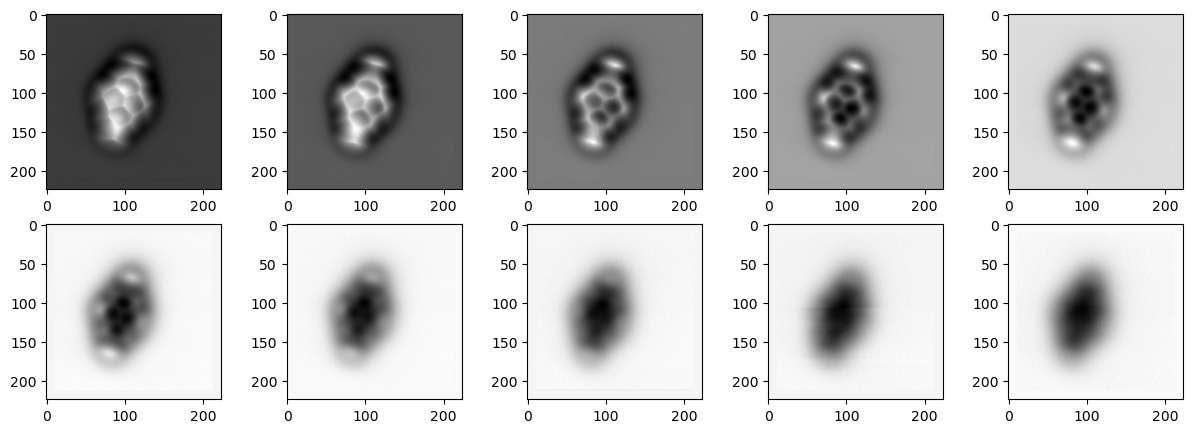

In [38]:
exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=0.9, normalize=True)

#10 images
f, axarr = plt.subplots(2,5, figsize=(15, 5))
axarr[0,0].imshow(exp_img[0], cmap = 'gray')
axarr[0,1].imshow(exp_img[1], cmap = 'gray')
axarr[0,2].imshow(exp_img[2], cmap = 'gray')
axarr[0,3].imshow(exp_img[3], cmap = 'gray')
axarr[0,4].imshow(exp_img[4], cmap = 'gray')
axarr[1,0].imshow(exp_img[5], cmap = 'gray')
axarr[1,1].imshow(exp_img[6], cmap = 'gray')
axarr[1,2].imshow(exp_img[7], cmap = 'gray')
axarr[1,3].imshow(exp_img[8], cmap = 'gray')
axarr[1,4].imshow(exp_img[9], cmap = 'gray')

In [60]:
"This molecule is in the test set"
#CID = 13615479
#SMILES = 'C1=CC2=CC(=CC3=C2C4=C(C=C3)C=C(C=C41)Br)Br'
#morgan_fp = morgan_fp_gen(SMILES, nBits=1024)
#split='test'
#corrugation = np.nan
#
#
#
#experimental_df = sample_df.append({'path':path,
#                           'CID':CID, 
#                           'SMILES':SMILES,
#                           'morgan_fp':morgan_fp,
#                           'split':split,
#                           'corrugation':corrugation
#                            }, ignore_index=True)
experimental_df = sample_df
CID = 13615479
experimental_df[experimental_df['CID']==CID]

path       CID  \
576224  /scratch/dataset/quam/K-1/Conformer3D_CID_1361...  13615479   

                                            SMILES  \
576224  C1=CC2=CC(=CC3=C2C4=C(C=C3)C=C(C=C41)Br)Br   

                                                morgan_fp split  corrugation  
576224  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0009

In [61]:
arr = list(experimental_df[experimental_df['CID']==13615479]['morgan_fp'])[0]
arr.sum()

14

In [62]:

exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=1, normalize=True)
with torch.no_grad():
    batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
    print(batched_tensor.size())
    predictions = model(batched_tensor)
    print(predictions.size())
    fp_pred = (torch.sigmoid(predictions) > 0.5)
    print(fp_pred.size())

exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()
print(exp_fp.shape)
print(exp_fp.sum())

torch.Size([1, 10, 224, 224])
torch.Size([1, 1024])
torch.Size([1, 1024])
(1024,)
30


In [63]:
fp_pred = (torch.sigmoid(predictions) > 0.5)
exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()
print(exp_fp.sum())

30


In [64]:
output_df = fp_screening_function(exp_fp, experimental_df, top_k = 5)

print('Is the correct CID in the top k candidates?',  CID in list(output_df['CID']))
output_df

Is the correct CID in the top k candidates? True


path       CID  \
325192  /scratch/dataset/quam/K-1/Conformer3D_CID_2307...  23073216   
576224  /scratch/dataset/quam/K-1/Conformer3D_CID_1361...  13615479   
247420  /scratch/dataset/quam/K-1/Conformer3D_CID_1098...  10980384   
552139  /scratch/dataset/quam/K-1/Conformer3D_CID_1378...  13782723   
542649  /scratch/dataset/quam/K-1/Conformer3D_CID_2339...  23397878   

                                                   SMILES  \
325192           C1=CC2=CC(=CC3=C2C4=C1C=CC(=C4C=C3)Br)Br   
576224         C1=CC2=CC(=CC3=C2C4=C(C=C3)C=C(C=C41)Br)Br   
247420   C1=CC2=C3C4=C1C=CC5=C4C6=C3C(=CC(=C6C=C5)Br)C=C2   
552139  C1=CC2=C3C4=C(C=C(C=C41)Br)C(=O)C5=C3C6=C(C2=O...   
542649  CC1=CC2=C3C(=C1)C(=O)C4=C5C3=C(C=C2)C(=O)C6=C5...   

                                                morgan_fp split  corrugation  \
325192  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0013   
576224  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0009   
247420  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0040   
552139  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0027   
542649  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0017   

        tanimoto  
325192  0.333333  
576224  0.294118  
247420  0.289474  
552139  0.279070  
542649  0.270833

In [65]:
gt_fp = list(experimental_df[experimental_df['CID']==13615479]['morgan_fp'])[0]
tanimoto_numpy(exp_fp.squeeze(), gt_fp)

0.29411764705882354

In [66]:
for interpolation_method in ['bilinear', 'nearest', 'bicubic']:
    print(f'Interpolation method: {interpolation_method}')
    for zoom in [ 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]:
        exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=zoom, interpolation=interpolation_method)
        with torch.no_grad():
            batched_tensor = exp_img.unsqueeze(dim = 0).to(device)

            predictions = model(batched_tensor)

            fp_pred = (torch.sigmoid(predictions) > 0.5)


        exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()

        
        
        print('zoom:', zoom, 'tanimoto', round(tanimoto_numpy(exp_fp.squeeze(), gt_fp), 2))

Interpolation method: bilinear
zoom: 0.5 tanimoto 0.09
zoom: 0.6 tanimoto 0.15
zoom: 0.7 tanimoto 0.15
zoom: 0.8 tanimoto 0.28
zoom: 0.9 tanimoto 0.33
zoom: 1 tanimoto 0.29
zoom: 1.1 tanimoto 0.29
zoom: 1.2 tanimoto 0.17
zoom: 1.3 tanimoto 0.18
zoom: 1.4 tanimoto 0.21
zoom: 1.5 tanimoto 0.23
Interpolation method: nearest
zoom: 0.5 tanimoto 0.11
zoom: 0.6 tanimoto 0.1
zoom: 0.7 tanimoto 0.15
zoom: 0.8 tanimoto 0.14
zoom: 0.9 tanimoto 0.21
zoom: 1 tanimoto 0.29
zoom: 1.1 tanimoto 0.19
zoom: 1.2 tanimoto 0.11
zoom: 1.3 tanimoto 0.09
zoom: 1.4 tanimoto 0.06
zoom: 1.5 tanimoto 0.09
Interpolation method: bicubic
zoom: 0.5 tanimoto 0.11
zoom: 0.6 tanimoto 0.15
zoom: 0.7 tanimoto 0.15
zoom: 0.8 tanimoto 0.26
zoom: 0.9 tanimoto 0.3
zoom: 1 tanimoto 0.3
zoom: 1.1 tanimoto 0.26
zoom: 1.2 tanimoto 0.19
zoom: 1.3 tanimoto 0.19
zoom: 1.4 tanimoto 0.19
zoom: 1.5 tanimoto 0.24


### 2-iodotriphenylene

In [13]:
sample_df = test_df
path = f'/home/{USER}/EXPERIMENTAL_IMAGES/RAW/2-Iodotriphenylene_88955426'
sorted(glob.glob(os.path.join(path,'*')))

['/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2-Iodotriphenylene_88955426/z058_1.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2-Iodotriphenylene_88955426/z066_2.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2-Iodotriphenylene_88955426/z074_3.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2-Iodotriphenylene_88955426/z082_4.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2-Iodotriphenylene_88955426/z090_5.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2-Iodotriphenylene_88955426/z098_6.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2-Iodotriphenylene_88955426/z106_7.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2-Iodotriphenylene_88955426/z114_8.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2-Iodotriphenylene_88955426/z122_9.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2-Iodotriphenylene_88955426/z130_10.jpg']

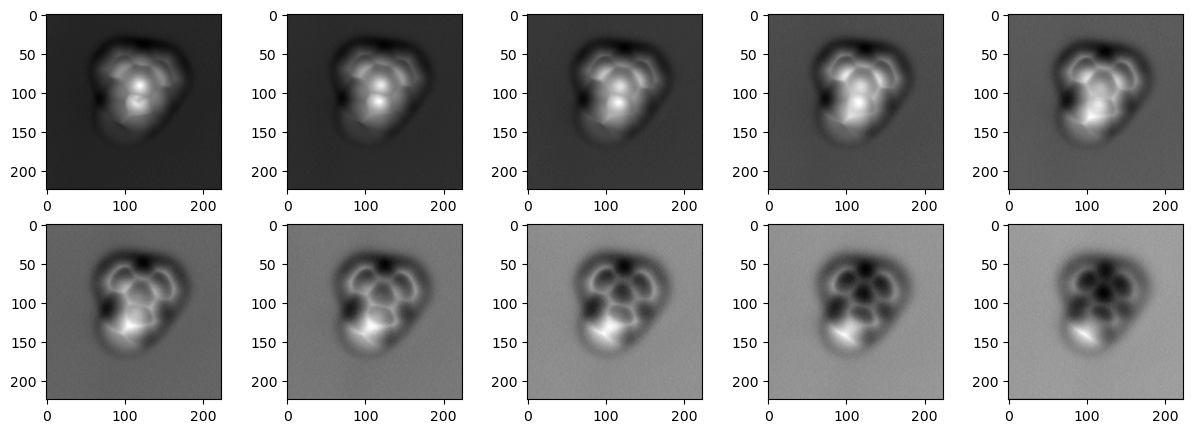

In [14]:
exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=1)
#10 images
f, axarr = plt.subplots(2,5, figsize=(15, 5))
axarr[0,0].imshow(exp_img[0], cmap = 'gray')
axarr[0,1].imshow(exp_img[1], cmap = 'gray')
axarr[0,2].imshow(exp_img[2], cmap = 'gray')
axarr[0,3].imshow(exp_img[3], cmap = 'gray')
axarr[0,4].imshow(exp_img[4], cmap = 'gray')
axarr[1,0].imshow(exp_img[5], cmap = 'gray')
axarr[1,1].imshow(exp_img[6], cmap = 'gray')
axarr[1,2].imshow(exp_img[7], cmap = 'gray')
axarr[1,3].imshow(exp_img[8], cmap = 'gray')
axarr[1,4].imshow(exp_img[9], cmap = 'gray')

In [27]:
exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=1)
with torch.no_grad():
    batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
    print(batched_tensor.size())
    predictions = model(batched_tensor)
    print(predictions.size())
    atom_count = torch.round(predictions) 
    print(atom_count.size())

atom_count = atom_count.cpu().numpy().astype(int).squeeze()
for atom, count in zip(['C', 'Br', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S', 'H'], atom_count):
    print(atom, ':', count)
print(f'Total atoms: {atom_count.sum()}')

torch.Size([1, 10, 224, 224])
torch.Size([10])
torch.Size([10])
C : 19
Br : 0
Cl : 0
F : 0
I : 0
N : 0
O : 0
P : 0
S : 0
H : 11
Total atoms: 30


## Test for several zooms

In [141]:
path = f'/home/{USER}/EXPERIMENTAL_IMAGES/2-Iodotriphenylene_88955426' 
exp_img_l = list()
for zoom in np.linspace(0.05, 1.5, 20):
    
    exp_img_l.append(load_exp_img_stack(path, dimensions = [224,224], zoom=zoom).unsqueeze(0))


In [142]:
exp_img_batch = torch.cat(exp_img_l, dim=0)
exp_img_batch.size()

torch.Size([20, 10, 224, 224])

In [175]:

# model and metrics initialization
model = effnet_10_chan(output_size=args.n_fp)



models_path = f'/home/{USER}/CODE/Pytorch-fingerprints/experiments/300k_1024_bit_big_zoom/models'
checkpoint = torch.load(os.path.join(models_path, 'checkpoint_150.pth'))

model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()
with torch.no_grad():
    batched_tensor = exp_img_batch.to(device)
    print(batched_tensor.size())
    predictions = model(batched_tensor)
    print(predictions.size())
    fp_pred = (torch.sigmoid(predictions) > 0.5)
    print(fp_pred.size())
    
exp_fp = fp_pred.cpu().numpy().astype(int)
zoom_dict = dict(zip(list(np.linspace(0.05, 1.5, 20)), list(tanimoto_numpy(exp_fp, gt_fp))))
zoom_dict = {k: v for k, v in sorted(zoom_dict.items(), key=lambda item: item[1], reverse=True)}
zoom_dict

torch.Size([20, 10, 224, 224])
torch.Size([20, 1024])
torch.Size([20, 1024])


{0.2789473684210526: 0.17857142857142858,
 0.43157894736842106: 0.15625,
 0.35526315789473684: 0.14285714285714285,
 1.2710526315789474: 0.08333333333333333,
 0.8131578947368422: 0.07692307692307693,
 1.1947368421052633: 0.07407407407407407,
 0.8894736842105264: 0.06976744186046512,
 1.118421052631579: 0.06976744186046512,
 0.5078947368421053: 0.06818181818181818,
 0.9657894736842105: 0.06818181818181818,
 1.0421052631578946: 0.06818181818181818,
 0.05: 0.05263157894736842,
 1.3473684210526315: 0.04,
 1.4236842105263159: 0.04,
 0.20263157894736844: 0.0392156862745098,
 0.5842105263157895: 0.0375,
 1.5: 0.037037037037037035,
 0.736842105263158: 0.028985507246376812,
 0.6605263157894737: 0.025,
 0.12631578947368421: 0.0}

0.2789473684210526 0.125


The prediction fails. The closest molecule in our dataset is 123757965, let's see if the network predicts this well

In [ ]:
output_df = fp_screening_function(gt_fp, test_df, top_k = 5)

print('Is the correct CID in the top k candidates?',  CID in list(output_df['CID']))
output_df

In [ ]:
true_CID = 123757965
molec_path = test_df[test_df['CID'] == true_CID]['path'].values[0]
 

fp_pred = predict_fp(model, molec_path, device,  thres = 0.5)
print('Total number of fingerprints', np.sum(fp_pred))

output_df = fp_screening_function(fp_pred, test_df, top_k = 5)

print('Is the correct CID in the top k candidates?',  true_CID in list(output_df['CID']))
output_df

The closest (but definately not close) molecule is well predicted. It may have something to do with it being an experimental image.



In [ ]:
true_CID = 123757965
molec_path = test_df[test_df['CID'] == true_CID]['path'].values[0]
 

fp_pred = predict_fp(model, molec_path, device,  thres = 0.5)
print('Total number of fingerprints', np.sum(fp_pred))

output_df = fp_screening_function(fp_pred, test_df, top_k = 5)

print('Is the correct CID in the top k candidates?',  true_CID in list(output_df['CID']))
output_df

In [ ]:
output_df = fp_screening_function(gt_fp, train_df, top_k = 5)

print('Is the correct CID in the top k candidates?',  CID in list(output_df['CID']))
output_df

### Add second candidates

In [101]:
### Add all molecules to experimental_df
path = '/aaa'

experimental_df = test_df
CID = 88955426
SMILES = 'C1=CC=C2C(=C1)C3=C(C=C(C=C3)I)C4=CC=CC=C24'
morgan_fp = morgan_fp_gen(SMILES, nBits=1024)
split='test'
corrugation = np.nan



experimental_df = experimental_df.append({'path':path,
                           'CID':CID, 
                           'SMILES':SMILES,
                           'morgan_fp':morgan_fp,
                           'split':split,
                           'corrugation':corrugation
                            }, ignore_index=True)
'29766 is included in the quam-afm dataset'
##CID = 29766
##SMILES = 'C1=C(C=C(C=C1Cl)Br)Cl'
##morgan_fp = morgan_fp_gen(SMILES, nBits=1024)
##split='test'
##corrugation = np.nan
##
##
##
##experimental_df = experimental_df.append({'path':path,
##                           'CID':CID, 
##                           'SMILES':SMILES,
##                           'morgan_fp':morgan_fp,
##                           'split':split,
##                           'corrugation':corrugation
##                            }, ignore_index=True)

CID = 67191
SMILES = 'C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C(=O)OC7=O)C(=O)OC2=O'
morgan_fp = morgan_fp_gen(SMILES, nBits=1024)
split='test'
corrugation = np.nan



experimental_df = experimental_df.append({'path':path,
                           'CID':CID, 
                           'SMILES':SMILES,
                           'morgan_fp':morgan_fp,
                           'split':split,
                           'corrugation':corrugation
                            }, ignore_index=True)


index_1 = experimental_df[experimental_df['CID'] == 130412167].index[0]
index_2 = experimental_df[experimental_df['CID'] == 88955426].index[0]
experimental_df[experimental_df['CID'] == 130412167].set_index(index_2)
experimental_df[experimental_df['CID'] == 88955426].index(index_1)

/tmp/ipykernel_56268/1116294038.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  experimental_df = experimental_df.append({'path':path,
/tmp/ipykernel_56268/1116294038.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  experimental_df = experimental_df.append({'path':path,


In [105]:
experimental_df[experimental_df['CID'] == 88955426].index[0]

279905

Is the correct CID in the top k candidates? True
First candidate: 130412167, second candidate: 88955426
Is the correct CID in the top k candidates? True
First candidate: 29766, second candidate: 84676
Is the correct CID in the top k candidates? True
First candidate: 67191, second candidate: 59464606


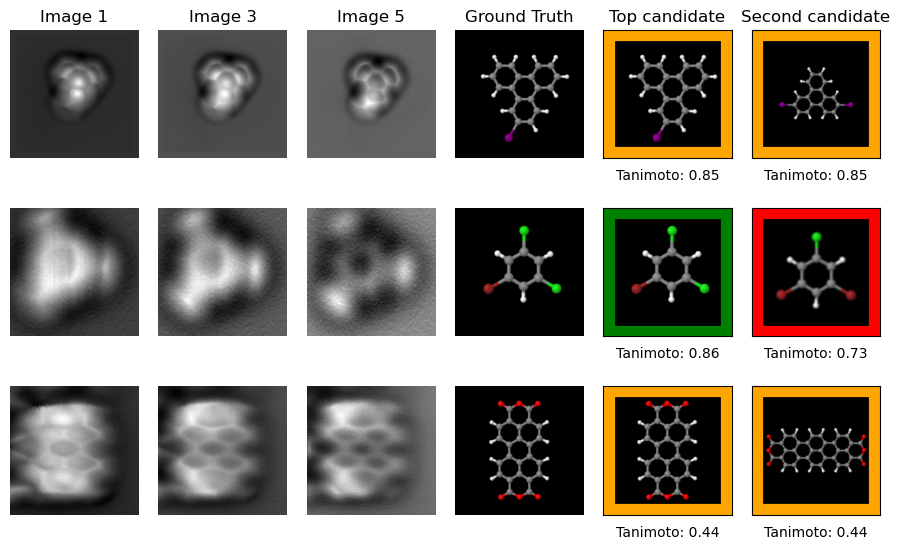

In [113]:
n_results = 3
fig, ax = plt.subplots(n_results, 6, figsize=(9, n_results*1.9))  # Adjust figsize according to your needs

path_list = [f'/home/{USER}/EXPERIMENTAL_IMAGES/RAW/2-Iodotriphenylene_88955426',
             f'/home/{USER}/EXPERIMENTAL_IMAGES/RAW/1-Bromo-3,5-dichlorobenzene',
             f'/home/{USER}/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA',
             ]
zoom_list = [0.9, 1.4, 1]
jmol_zoom_list = [1, 1.3, 1]

CID_list = [88955426, 29766, 67191]
second_cid_list = [130412167, 84676, 59464606]
jmol_paths = ['/home/mgonzalez/EXPERIMENTAL_IMAGES/jmol_images/2-iodotriphenylene.jpg',
    '/home/mgonzalez/EXPERIMENTAL_IMAGES/jmol_images/1-bromo-3,5-dichlorobenzene.jpg',
    '/home/mgonzalez/EXPERIMENTAL_IMAGES/jmol_images/PTCDA.jpg']

titles = ['Image 1', 'Image 3', 'Image 5', 'Ground Truth', 'Top candidate', 'Second candidate']
for i, path in enumerate(path_list):
    gt_jmol = load_jmol(jmol_paths[i], zoom=jmol_zoom_list[i])
    pred_jmol = load_jmol(jmol_paths[i], zoom=jmol_zoom_list[i])

    exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=zoom_list[i], interpolation='bilinear')
    with torch.no_grad():
        batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
        predictions = model(batched_tensor)
        fp_pred = (torch.sigmoid(predictions) > 0.5)

    exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()
    output_df = fp_screening_function(exp_fp, experimental_df, top_k = 20)
    tanimoto = output_df.iloc[0]['tanimoto']
    tanimoto_second = output_df.iloc[1]['tanimoto']
    print('Is the correct CID in the top k candidates?',  CID_list[i] in list(output_df['CID']))
    print(f"First candidate: {output_df.iloc[0]['CID']}, second candidate: {output_df.iloc[1]['CID']}")
   ## print('----------------------')
   ## print(output_df.iloc[0:5])
   ## print('======================')

    cid_second = second_cid_list[i]
    if i == 1:
        pred_second_jmol = load_jmol_image(cid_second, dimension=[224,224], zoom=0.5)
    else:
        pred_second_jmol = load_jmol_image(cid_second, dimension=[224,224], zoom=1)
    
    ax[i,0].imshow(exp_img[1], cmap='gray')
    ax[i,0].axis('off')
    ax[i,1].imshow(exp_img[3], cmap='gray')
    ax[i,1].axis('off')
    ax[i,2].imshow(exp_img[5], cmap='gray')
    ax[i,2].axis('off')
    ax[i,3].imshow(gt_jmol)
    ax[i,3].axis('off')
    ax[i,4].imshow(pred_jmol)
    ax[i,5].imshow(pred_second_jmol)


    
    color = 'green'
    green_rect = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')

    color = 'red'
    red_rect = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
    
    color = 'orange'
    yellow_rect1 = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
    yellow_rect2 = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
    
    
    ax[i,4].set_xticks([])
    ax[i,4].set_yticks([])
    ax[i,4].set_xlabel(f'Tanimoto: {tanimoto:.2f}', fontsize=10)  # Adjust fontsize according to your needs
    

    ax[i,5].set_xticks([])
    ax[i,5].set_yticks([])
    ax[i,5].set_xlabel(f'Tanimoto: {tanimoto_second:.2f}', fontsize=10)  # Adjust fontsize according to your needs
    
    if ((i == 0)|(i ==2)):
        
        ax[i,4].add_patch(yellow_rect1)
        ax[i,5].add_patch(yellow_rect2)
    if i==1:
        ax[i,4].add_patch(green_rect)
        ax[i,5].add_patch(red_rect)
    
    # Setting titles for each column
    if i == 0:
        for j in range(6):
            ax[i,j].set_title(titles[j])

#######################################

plt.tight_layout()
plt.savefig('/home/mgonzalez/CODE/Pytorch-fingerprints/figures/experimental_test/experimental_identification_second_candidates_tie.jpg')
plt.show()


In [36]:
experimental_df[experimental_df['CID'] == 29766]

path    CID  \
163425  /scratch/dataset/quam/K-1/Conformer3D_CID_2976...  29766   
279906                                               None  29766   

                       SMILES  \
163425  C1=C(C=C(C=C1Cl)Br)Cl   
279906  C1=C(C=C(C=C1Cl)Br)Cl   

                                                morgan_fp split  corrugation  
163425  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0004  
279906  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test          NaN

In [27]:
output_df

path        CID  \
279907                                               None      67191   
103812  /scratch/dataset/quam/K-1/Conformer3D_CID_5946...   59464606   
1245    /scratch/dataset/quam/K-1/Conformer3D_CID_1374...  137432859   
70616   /scratch/dataset/quam/K-1/Conformer3D_CID_7965...      79657   
133912  /scratch/dataset/quam/K-1/Conformer3D_CID_1124...   11249724   
90900   /scratch/dataset/quam/K-1/Conformer3D_CID_1360...     136008   
112232  /scratch/dataset/quam/K-1/Conformer3D_CID_8617...   86177626   
95817   /scratch/dataset/quam/K-1/Conformer3D_CID_2224...   22245515   
224513  /scratch/dataset/quam/K-1/Conformer3D_CID_5946...   59464612   
31213   /scratch/dataset/quam/K-1/Conformer3D_CID_3334...     333490   
3979    /scratch/dataset/quam/K-1/Conformer3D_CID_1059...     105969   
7632    /scratch/dataset/quam/K-1/Conformer3D_CID_1374...  137432761   
101195  /scratch/dataset/quam/K-1/Conformer3D_CID_4525...     452587   
91213   /scratch/dataset/quam/K-1/Conformer3D_CID_1361...     136154   
71317   /scratch/dataset/quam/K-1/Conformer3D_CID_5957...   59575049   
26357   /scratch/dataset/quam/K-1/Conformer3D_CID_5946...   59464614   
103982  /scratch/dataset/quam/K-1/Conformer3D_CID_5983...   59832180   
88356   /scratch/dataset/quam/K-1/Conformer3D_CID_1318...  131862339   
48812   /scratch/dataset/quam/K-1/Conformer3D_CID_1086...   10860536   
19489   /scratch/dataset/quam/K-1/Conformer3D_CID_4525...     452588   

                                                   SMILES  \
279907  C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C...   
103812  C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C...   
1245    C1=CC=C2C(=C1)C3=C(C4=C(C=C3)C5=CC=CC=C5C4=O)C...   
70616   CN1C(=O)C2=C3C(=CC=C4C3=C(C=C2)C5=C6C4=CC=C7C6...   
133912  CN1C(=O)C2=C3C(=CC=C4C3=C(C=C2)C5=C6C4=CC=C7C6...   
90900   C1=CC=C2C3=C4C5=C(C2=C1)C=CC=C5C6=CC=CC7=C6C4=...   
112232  C1=CC=C2C(=C1)C3=C2C4=C5C(=C4C=C3)C=CC6=C5C7=C...   
95817   C1=CC=C2C(=C1)C3=C(C4=CC=CC=C43)C5=C2C6=CC=CC=C65   
224513  CN1C(=O)C2=C3C(=CC=C4C3=C(C=C2)C5=C6C4=CC=C7C6...   
31213   CN1C(=O)C2=C3C(=CC=C4C3=C(C=C2)C5=C6C4=CC=C7C6...   
3979    CN1C(=O)C2=C3C(=CC=C4C3=C(C=C2)C5=C6C4=CC=C7C6...   
7632    C1=CC=C2C(=C1)C3=C(C2=O)C4=C(C=C3)C5=C(C6=CC=C...   
101195  C1=CC(=C2C(=O)C=CC3=C2C1=C4C=CC(=O)C5=C(C=CC3=...   
91213   C1=CC=C2C3=C4C5=C(C2=C1)C=CC6=C5C7=C(C=CC8=C7C...   
71317   C1=CC=C2C3=CC=CC=C4C5=C6C4=C3C2=C7C(=C1)C8=C7C...   
26357   CC1=C2C=CC=C3C2=C(C=C1)C4=CC=C5C6=CC=C7C8=C(C=...   
103982  CC1=C2C=CC=C3C2=C(C=C1)C4=CC=C5C6=C(C=CC3=C46)...   
88356   C1=CC2=C3C4=C1C=CC5=C4C6=C(C=C5)C(=O)C7=C6C3=C...   
48812   C1=CC=C2C(=C1)C3=C(C4=CC=CC=C4C3=O)C5=C2C(=O)C...   
19489   C1=CC2=C3C=CC=C4C3=C5C6=C(C=CC=C6C4=O)C7=C8C5=...   

                                                morgan_fp split  corrugation  \
279907  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test          NaN   
103812  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0042   
1245    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       1.7687   
70616   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.1194   
133912  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0864   
90900   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0030   
112232  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0095   
95817   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0026   
224513  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.1069   
31213   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0963   
3979    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0227   
7632    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       1.3987   
101195  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0040   
91213   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0025   
71317   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 

59464606


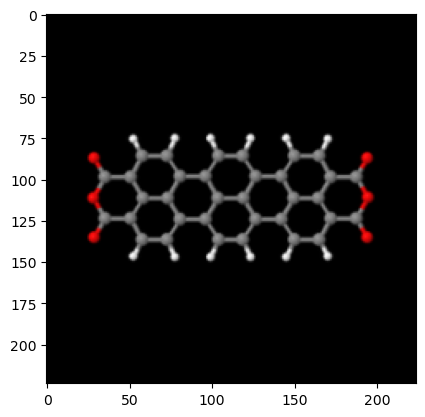

In [25]:
cid = output_df.iloc[1]['CID']
print(cid)
image = load_jmol_image(cid, dimension=[224,224], zoom=1)
plt.imshow(image)

#### Now let's add the last experimental molecule, 2,7-Dibromopyrene-Cu111,  where there is a mistake

In [114]:
path = f'/home/{USER}/EXPERIMENTAL_IMAGES/RAW/2,7-Dibromopyrene-Cu111/image_stack/stack_further' 
sample_df = test_df
experimental_df = sample_df


exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=1, normalize=True)
with torch.no_grad():
    batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
    print(batched_tensor.size())
    predictions = model(batched_tensor)
    print(predictions.size())
    fp_pred = (torch.sigmoid(predictions) > 0.5)
    print(fp_pred.size())

exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()
print(exp_fp.shape)
print(exp_fp.sum())

fp_pred = (torch.sigmoid(predictions) > 0.5)
exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()

output_df = fp_screening_function(exp_fp, experimental_df, top_k = 5)

print('Is the correct CID in the top k candidates?',  CID in list(output_df['CID']))
output_df

torch.Size([1, 10, 224, 224])
torch.Size([1, 1024])
torch.Size([1, 1024])
(1024,)
30
Is the correct CID in the top k candidates? False


path       CID  \
325192  /scratch/dataset/quam/K-1/Conformer3D_CID_2307...  23073216   
576224  /scratch/dataset/quam/K-1/Conformer3D_CID_1361...  13615479   
247420  /scratch/dataset/quam/K-1/Conformer3D_CID_1098...  10980384   
552139  /scratch/dataset/quam/K-1/Conformer3D_CID_1378...  13782723   
542649  /scratch/dataset/quam/K-1/Conformer3D_CID_2339...  23397878   

                                                   SMILES  \
325192           C1=CC2=CC(=CC3=C2C4=C1C=CC(=C4C=C3)Br)Br   
576224         C1=CC2=CC(=CC3=C2C4=C(C=C3)C=C(C=C41)Br)Br   
247420   C1=CC2=C3C4=C1C=CC5=C4C6=C3C(=CC(=C6C=C5)Br)C=C2   
552139  C1=CC2=C3C4=C(C=C(C=C41)Br)C(=O)C5=C3C6=C(C2=O...   
542649  CC1=CC2=C3C(=C1)C(=O)C4=C5C3=C(C=C2)C(=O)C6=C5...   

                                                morgan_fp split  corrugation  \
325192  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0013   
576224  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0009   
247420  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0040   
552139  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0027   
542649  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  test       0.0017   

        tanimoto  
325192  0.333333  
576224  0.294118  
247420  0.289474  
552139  0.279070  
542649  0.270833

In [122]:
true_CID = 13615479
molec_path = experimental_df[experimental_df['CID']==13615479]

13615479


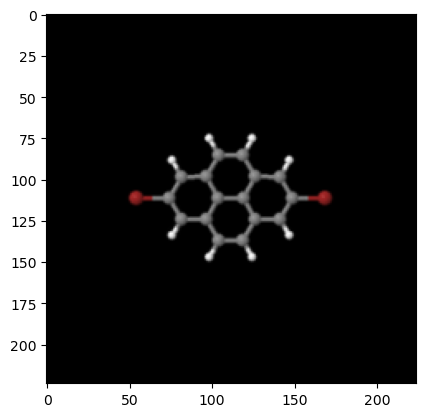

In [130]:
pred_CID, second_CID = output_df.iloc[0:2]['CID']
print(second_CID)
image = load_jmol_image(second_CID, dimension=[224,224], zoom=1)
plt.imshow(image)

In [138]:
second_jmol.dtype

dtype('uint8')

23073216 13615479


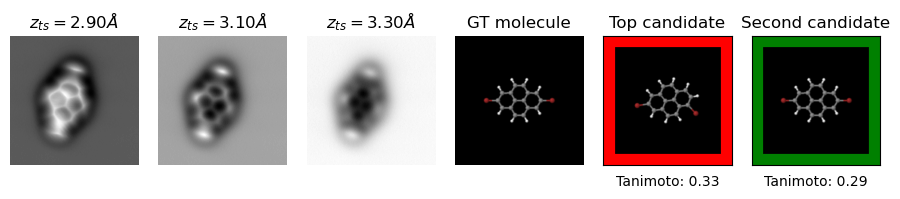

In [137]:
# Final figure:
n_results=1



titles = ['$z_{ts}=2.90 \AA$', '$z_{ts}=3.10 \AA$', '$z_{ts}=3.30 \AA$', 'GT molecule', 'Top candidate', 'Second candidate']
fig, ax = plt.subplots(n_results, 6, figsize=(9, n_results*2.1))  # Adjust figsize according to your needs
    
    

img_1, img_3, img_5 = exp_img[1], exp_img[3], exp_img[5]

gt_jmol = load_jmol_image(true_CID, dimension=[224,224], zoom=1)

pred_CID, second_CID = output_df.iloc[0:2]['CID']
tanimoto, tanimoto_second = output_df.iloc[0:2]['tanimoto']
print(pred_CID, second_CID)

pred_jmol = load_jmol_image(pred_CID, dimension=[224,224], zoom=1)
second_jmol = load_jmol_image(second_CID, dimension=[224,224], zoom=1)


ax[0].imshow(img_1, cmap='gray')
ax[0].axis('off')
ax[1].imshow(img_3, cmap='gray')
ax[1].axis('off')
ax[2].imshow(img_5, cmap='gray')
ax[2].axis('off')
ax[3].imshow(gt_jmol)
ax[3].axis('off')
ax[4].imshow(pred_jmol)
ax[5].imshow(second_jmol)



color = 'green'
green_rect = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')

color = 'red'
red_rect = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')

ax[4].add_patch(red_rect)
ax[4].set_xticks([])
ax[4].set_yticks([])
ax[4].set_xlabel(f'Tanimoto: {tanimoto:.2f}', fontsize=10)  # Adjust fontsize according to your needs


ax[5].add_patch(green_rect)
ax[5].set_xticks([])
ax[5].set_yticks([])
ax[5].set_xlabel(f'Tanimoto: {tanimoto_second:.2f}', fontsize=10)  # Adjust fontsize according to your needs

# Setting titles for each column

for j in range(6):
    ax[j].set_title(titles[j])

#######################################

plt.tight_layout()
###plt.savefig('vs_bad_pred.png')

plt.show()

In [7]:
import numpy as np
from scipy.ndimage import rotate

def rotate_image(image_array, angle, reshape=True, mode='nearest'):
    """
    Rotate a given numpy array image by the specified angle.

    Parameters:
    - image_array (numpy.ndarray): The input image array.
    - angle (float): The rotation angle in degrees.
    - reshape (bool): If True, the output shape will change. If False, the output shape is the same as the input.
    - mode (str): The mode parameter determines how the input array is extended when the filter overlaps a border.

    Returns:
    - numpy.ndarray: The rotated image array.
    """
    return rotate(image_array, angle, reshape=reshape, mode=mode)

23073216 13615479


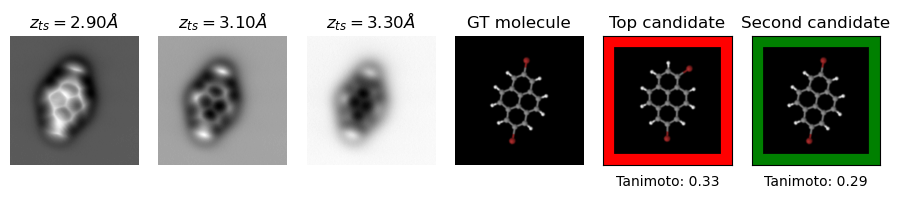

In [144]:
# Final figure:
n_results=1



titles = ['$z_{ts}=2.90 \AA$', '$z_{ts}=3.10 \AA$', '$z_{ts}=3.30 \AA$', 'GT molecule', 'Top candidate', 'Second candidate']
fig, ax = plt.subplots(n_results, 6, figsize=(9, n_results*2.1))  # Adjust figsize according to your needs
    
    

img_1, img_3, img_5 = exp_img[1], exp_img[3], exp_img[5]

gt_jmol = load_jmol_image(true_CID, dimension=[224,224], zoom=0.7)

pred_CID, second_CID = output_df.iloc[0:2]['CID']
tanimoto, tanimoto_second = output_df.iloc[0:2]['tanimoto']
print(pred_CID, second_CID)

pred_jmol = load_jmol_image(pred_CID, dimension=[224,224], zoom=0.7)
second_jmol = load_jmol_image(second_CID, dimension=[224,224], zoom=0.7)

# rotation 
rot_gt_jmol = rotate_image(gt_jmol, angle=80)
pred_jmol = rotate_image(pred_jmol, angle=80)
second_jmol = rotate_image(second_jmol, angle=80)


ax[0].imshow(img_1, cmap='gray')
ax[0].axis('off')
ax[1].imshow(img_3, cmap='gray')
ax[1].axis('off')
ax[2].imshow(img_5, cmap='gray')
ax[2].axis('off')
ax[3].imshow(rot_gt_jmol)
ax[3].axis('off')
ax[4].imshow(pred_jmol)
ax[5].imshow(second_jmol)



color = 'green'
green_rect = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')

color = 'red'
red_rect = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')

ax[4].add_patch(red_rect)
ax[4].set_xticks([])
ax[4].set_yticks([])
ax[4].set_xlabel(f'Tanimoto: {tanimoto:.2f}', fontsize=10)  # Adjust fontsize according to your needs


ax[5].add_patch(green_rect)
ax[5].set_xticks([])
ax[5].set_yticks([])
ax[5].set_xlabel(f'Tanimoto: {tanimoto_second:.2f}', fontsize=10)  # Adjust fontsize according to your needs

# Setting titles for each column

for j in range(6):
    ax[j].set_title(titles[j])

#######################################

plt.tight_layout()
###plt.savefig('vs_bad_pred.png')

plt.show()

#### rotate the molecules from the identification result

/tmp/ipykernel_56268/2141563060.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  experimental_df = experimental_df.append({'path':path,
/tmp/ipykernel_56268/2141563060.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  experimental_df = experimental_df.append({'path':path,


Is the correct CID in the top k candidates? True
First candidate: 130412167, second candidate: 88955426
Is the correct CID in the top k candidates? True
First candidate: 29766, second candidate: 84676
Is the correct CID in the top k candidates? True
First candidate: 67191, second candidate: 59464606


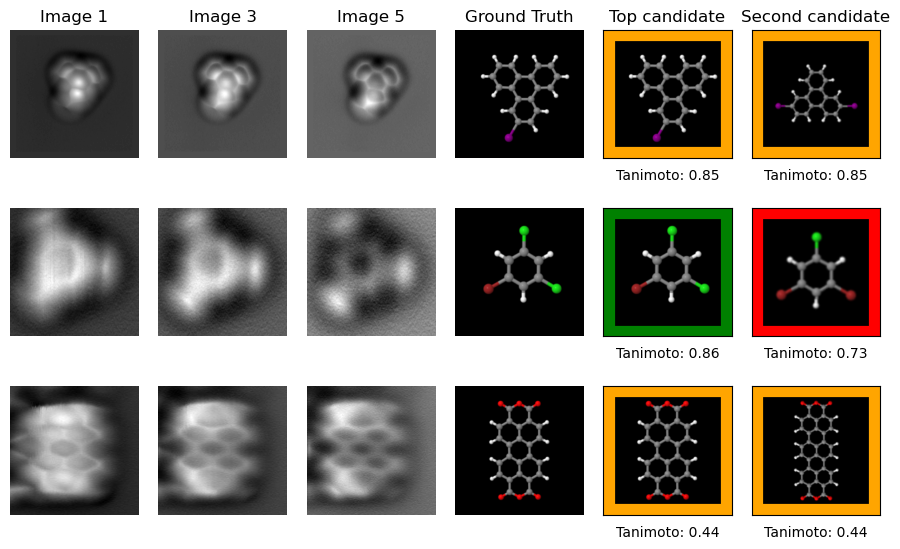

In [157]:
### Add all molecules to experimental_df
path = '/aaa'

experimental_df = test_df
CID = 88955426
SMILES = 'C1=CC=C2C(=C1)C3=C(C=C(C=C3)I)C4=CC=CC=C24'
morgan_fp = morgan_fp_gen(SMILES, nBits=1024)
split='test'
corrugation = np.nan



experimental_df = experimental_df.append({'path':path,
                           'CID':CID, 
                           'SMILES':SMILES,
                           'morgan_fp':morgan_fp,
                           'split':split,
                           'corrugation':corrugation
                            }, ignore_index=True)
'29766 is included in the quam-afm dataset'
##CID = 29766
##SMILES = 'C1=C(C=C(C=C1Cl)Br)Cl'
##morgan_fp = morgan_fp_gen(SMILES, nBits=1024)
##split='test'
##corrugation = np.nan
##
##
##
##experimental_df = experimental_df.append({'path':path,
##                           'CID':CID, 
##                           'SMILES':SMILES,
##                           'morgan_fp':morgan_fp,
##                           'split':split,
##                           'corrugation':corrugation
##                            }, ignore_index=True)

CID = 67191
SMILES = 'C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C(=O)OC7=O)C(=O)OC2=O'
morgan_fp = morgan_fp_gen(SMILES, nBits=1024)
split='test'
corrugation = np.nan



experimental_df = experimental_df.append({'path':path,
                           'CID':CID, 
                           'SMILES':SMILES,
                           'morgan_fp':morgan_fp,
                           'split':split,
                           'corrugation':corrugation
                            }, ignore_index=True)


index_1 = experimental_df[experimental_df['CID'] == 130412167].index[0]
index_2 = experimental_df[experimental_df['CID'] == 88955426].index[0]
#experimental_df[experimental_df['CID'] == 130412167].set_index(index_2)
#experimental_df[experimental_df['CID'] == 88955426].index(index_1)



n_results = 3
fig, ax = plt.subplots(n_results, 6, figsize=(9, n_results*1.9))  # Adjust figsize according to your needs

path_list = [f'/home/{USER}/EXPERIMENTAL_IMAGES/RAW/2-Iodotriphenylene_88955426',
             f'/home/{USER}/EXPERIMENTAL_IMAGES/RAW/1-Bromo-3,5-dichlorobenzene',
             f'/home/{USER}/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA',
             ]
zoom_list = [0.9, 1.4, 1]
jmol_zoom_list = [1, 1.3, 1]

CID_list = [88955426, 29766, 67191]
second_cid_list = [130412167, 84676, 59464606]
jmol_paths = ['/home/mgonzalez/EXPERIMENTAL_IMAGES/jmol_images/2-iodotriphenylene.jpg',
    '/home/mgonzalez/EXPERIMENTAL_IMAGES/jmol_images/1-bromo-3,5-dichlorobenzene.jpg',
    '/home/mgonzalez/EXPERIMENTAL_IMAGES/jmol_images/PTCDA.jpg']

titles = ['Image 1', 'Image 3', 'Image 5', 'Ground Truth', 'Top candidate', 'Second candidate']
for i, path in enumerate(path_list):
    gt_jmol = load_jmol(jmol_paths[i], zoom=jmol_zoom_list[i])
    pred_jmol = load_jmol(jmol_paths[i], zoom=jmol_zoom_list[i])

    exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=zoom_list[i], interpolation='bilinear')
    with torch.no_grad():
        batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
        predictions = model(batched_tensor)
        fp_pred = (torch.sigmoid(predictions) > 0.5)

    exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()
    output_df = fp_screening_function(exp_fp, experimental_df, top_k = 20)
    tanimoto = output_df.iloc[0]['tanimoto']
    tanimoto_second = output_df.iloc[1]['tanimoto']
    print('Is the correct CID in the top k candidates?',  CID_list[i] in list(output_df['CID']))
    print(f"First candidate: {output_df.iloc[0]['CID']}, second candidate: {output_df.iloc[1]['CID']}")
   ## print('----------------------')
   ## print(output_df.iloc[0:5])
   ## print('======================')

    cid_second = second_cid_list[i]
    if i == 1:
        pred_second_jmol = load_jmol_image(cid_second, dimension=[224,224], zoom=0.5)
    
    elif i == 2:
        pred_second_jmol = load_jmol_image(cid_second, dimension=[224,224], zoom=1)
        pred_second_jmol = rotate_image(pred_second_jmol, angle=90)
    else:
        pred_second_jmol = load_jmol_image(cid_second, dimension=[224,224], zoom=0.9)
    
    ax[i,0].imshow(exp_img[1], cmap='gray')
    ax[i,0].axis('off')
    ax[i,1].imshow(exp_img[3], cmap='gray')
    ax[i,1].axis('off')
    ax[i,2].imshow(exp_img[5], cmap='gray')
    ax[i,2].axis('off')
    ax[i,3].imshow(gt_jmol)
    ax[i,3].axis('off')
    ax[i,4].imshow(pred_jmol)
    ax[i,5].imshow(pred_second_jmol)


    
    color = 'green'
    green_rect = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')

    color = 'red'
    red_rect = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
    
    color = 'orange'
    yellow_rect1 = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
    yellow_rect2 = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
    
    
    ax[i,4].set_xticks([])
    ax[i,4].set_yticks([])
    ax[i,4].set_xlabel(f'Tanimoto: {tanimoto:.2f}', fontsize=10)  # Adjust fontsize according to your needs
    

    ax[i,5].set_xticks([])
    ax[i,5].set_yticks([])
    ax[i,5].set_xlabel(f'Tanimoto: {tanimoto_second:.2f}', fontsize=10)  # Adjust fontsize according to your needs
    
    if ((i == 0)|(i ==2)):
        
        ax[i,4].add_patch(yellow_rect1)
        ax[i,5].add_patch(yellow_rect2)
    if i==1:
        ax[i,4].add_patch(green_rect)
        ax[i,5].add_patch(red_rect)
    
    # Setting titles for each column
    if i == 0:
        for j in range(6):
            ax[i,j].set_title(titles[j])

#######################################

plt.tight_layout()
plt.savefig('/home/mgonzalez/CODE/Pytorch-fingerprints/figures/experimental_test/experimental_identification_second_candidates_tie.jpg')
plt.show()


/tmp/ipykernel_56268/1008222232.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  experimental_df = experimental_df.append({'path':path,
/tmp/ipykernel_56268/1008222232.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  experimental_df = experimental_df.append({'path':path,


Is the correct CID in the top k candidates? True
First candidate: 130412167, second candidate: 88955426
Is the correct CID in the top k candidates? True
First candidate: 29766, second candidate: 84676
Is the correct CID in the top k candidates? True
First candidate: 67191, second candidate: 59464606
torch.Size([1, 10, 224, 224])
torch.Size([1, 1024])
torch.Size([1, 1024])
(1024,)
30
Is the correct CID in the top k candidates? False
23073216 13615479


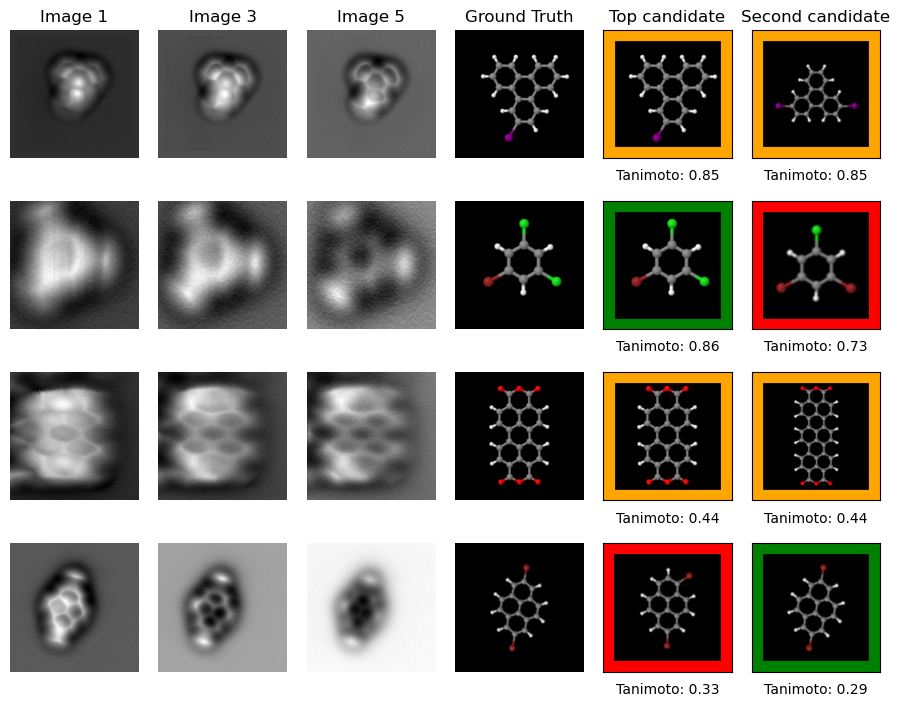

In [167]:
### Add all molecules to experimental_df
path = '/aaa'

experimental_df = test_df
CID = 88955426
SMILES = 'C1=CC=C2C(=C1)C3=C(C=C(C=C3)I)C4=CC=CC=C24'
morgan_fp = morgan_fp_gen(SMILES, nBits=1024)
split='test'
corrugation = np.nan



experimental_df = experimental_df.append({'path':path,
                           'CID':CID, 
                           'SMILES':SMILES,
                           'morgan_fp':morgan_fp,
                           'split':split,
                           'corrugation':corrugation
                            }, ignore_index=True)
'29766 is included in the quam-afm dataset'
##CID = 29766
##SMILES = 'C1=C(C=C(C=C1Cl)Br)Cl'
##morgan_fp = morgan_fp_gen(SMILES, nBits=1024)
##split='test'
##corrugation = np.nan
##
##
##
##experimental_df = experimental_df.append({'path':path,
##                           'CID':CID, 
##                           'SMILES':SMILES,
##                           'morgan_fp':morgan_fp,
##                           'split':split,
##                           'corrugation':corrugation
##                            }, ignore_index=True)

CID = 67191
SMILES = 'C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C(=O)OC7=O)C(=O)OC2=O'
morgan_fp = morgan_fp_gen(SMILES, nBits=1024)
split='test'
corrugation = np.nan



experimental_df = experimental_df.append({'path':path,
                           'CID':CID, 
                           'SMILES':SMILES,
                           'morgan_fp':morgan_fp,
                           'split':split,
                           'corrugation':corrugation
                            }, ignore_index=True)


index_1 = experimental_df[experimental_df['CID'] == 130412167].index[0]
index_2 = experimental_df[experimental_df['CID'] == 88955426].index[0]
#experimental_df[experimental_df['CID'] == 130412167].set_index(index_2)
#experimental_df[experimental_df['CID'] == 88955426].index(index_1)



n_results = 4
fig, ax = plt.subplots(n_results, 6, figsize=(9, n_results*1.8))  # Adjust figsize according to your needs

path_list = [f'/home/{USER}/EXPERIMENTAL_IMAGES/RAW/2-Iodotriphenylene_88955426',
             f'/home/{USER}/EXPERIMENTAL_IMAGES/RAW/1-Bromo-3,5-dichlorobenzene',
             f'/home/{USER}/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA',
             ]
zoom_list = [0.9, 1.4, 1]
jmol_zoom_list = [1, 1.3, 1]

CID_list = [88955426, 29766, 67191]
second_cid_list = [130412167, 84676, 59464606]
jmol_paths = ['/home/mgonzalez/EXPERIMENTAL_IMAGES/jmol_images/2-iodotriphenylene.jpg',
    '/home/mgonzalez/EXPERIMENTAL_IMAGES/jmol_images/1-bromo-3,5-dichlorobenzene.jpg',
    '/home/mgonzalez/EXPERIMENTAL_IMAGES/jmol_images/PTCDA.jpg']

titles = ['Image 1', 'Image 3', 'Image 5', 'Ground Truth', 'Top candidate', 'Second candidate']
for i, path in enumerate(path_list):
    gt_jmol = load_jmol(jmol_paths[i], zoom=jmol_zoom_list[i])
    pred_jmol = load_jmol(jmol_paths[i], zoom=jmol_zoom_list[i])

    exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=zoom_list[i], interpolation='bilinear')
    with torch.no_grad():
        batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
        predictions = model(batched_tensor)
        fp_pred = (torch.sigmoid(predictions) > 0.5)

    exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()
    output_df = fp_screening_function(exp_fp, experimental_df, top_k = 20)
    tanimoto = output_df.iloc[0]['tanimoto']
    tanimoto_second = output_df.iloc[1]['tanimoto']
    print('Is the correct CID in the top k candidates?',  CID_list[i] in list(output_df['CID']))
    print(f"First candidate: {output_df.iloc[0]['CID']}, second candidate: {output_df.iloc[1]['CID']}")
   ## print('----------------------')
   ## print(output_df.iloc[0:5])
   ## print('======================')

    cid_second = second_cid_list[i]
    if i == 1:
        pred_second_jmol = load_jmol_image(cid_second, dimension=[224,224], zoom=0.5)
    
    elif i == 2:
        pred_second_jmol = load_jmol_image(cid_second, dimension=[224,224], zoom=1)
        pred_second_jmol = rotate_image(pred_second_jmol, angle=90)
    else:
        pred_second_jmol = load_jmol_image(cid_second, dimension=[224,224], zoom=0.9)
    
    ax[i,0].imshow(exp_img[1], cmap='gray')
    ax[i,0].axis('off')
    ax[i,1].imshow(exp_img[3], cmap='gray')
    ax[i,1].axis('off')
    ax[i,2].imshow(exp_img[5], cmap='gray')
    ax[i,2].axis('off')
    ax[i,3].imshow(gt_jmol)
    ax[i,3].axis('off')
    ax[i,4].imshow(pred_jmol)
    ax[i,5].imshow(pred_second_jmol)


    
    color = 'green'
    green_rect = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')

    color = 'red'
    red_rect = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
    
    color = 'orange'
    yellow_rect1 = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
    yellow_rect2 = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
    
    
    ax[i,4].set_xticks([])
    ax[i,4].set_yticks([])
    ax[i,4].set_xlabel(f'Tanimoto: {tanimoto:.2f}', fontsize=10)  # Adjust fontsize according to your needs
    

    ax[i,5].set_xticks([])
    ax[i,5].set_yticks([])
    ax[i,5].set_xlabel(f'Tanimoto: {tanimoto_second:.2f}', fontsize=10)  # Adjust fontsize according to your needs
    
    if ((i == 0)|(i ==2)):
        
        ax[i,4].add_patch(yellow_rect1)
        ax[i,5].add_patch(yellow_rect2)
    if i==1:
        ax[i,4].add_patch(green_rect)
        ax[i,5].add_patch(red_rect)
    
    # Setting titles for each column
    if i == 0:
        for j in range(6):
            ax[i,j].set_title(titles[j])

####################################### 

"""Last experimental molecule, since it is a mistake we compute it separately"""


path = f'/home/{USER}/EXPERIMENTAL_IMAGES/RAW/2,7-Dibromopyrene-Cu111/image_stack/stack_further' 
sample_df = test_df
experimental_df = sample_df


exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=1.0, normalize=True)
with torch.no_grad():
    batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
    print(batched_tensor.size())
    predictions = model(batched_tensor)
    print(predictions.size())
    fp_pred = (torch.sigmoid(predictions) > 0.5)
    print(fp_pred.size())

exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()
print(exp_fp.shape)
print(exp_fp.sum())

fp_pred = (torch.sigmoid(predictions) > 0.5)
exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()

output_df = fp_screening_function(exp_fp, experimental_df, top_k = 5)

print('Is the correct CID in the top k candidates?',  CID in list(output_df['CID']))




# Final figure:
n_results=1



    
true_CID = 13615479

img_1, img_3, img_5 = exp_img[1], exp_img[3], exp_img[5]

gt_jmol = load_jmol_image(true_CID, dimension=[224,224], zoom=0.7)

pred_CID, second_CID = output_df.iloc[0:2]['CID']
tanimoto, tanimoto_second = output_df.iloc[0:2]['tanimoto']
print(pred_CID, second_CID)

pred_jmol = load_jmol_image(pred_CID, dimension=[224,224], zoom=0.7)
second_jmol = load_jmol_image(second_CID, dimension=[224,224], zoom=0.7)

# rotation 
rot_gt_jmol = rotate_image(gt_jmol, angle=80)
pred_jmol = rotate_image(pred_jmol, angle=80)
second_jmol = rotate_image(second_jmol, angle=80)


ax[3,0].imshow(img_1, cmap='gray')
ax[3,0].axis('off')
ax[3,1].imshow(img_3, cmap='gray')
ax[3,1].axis('off')
ax[3,2].imshow(img_5, cmap='gray')
ax[3,2].axis('off')
ax[3,3].imshow(rot_gt_jmol)
ax[3,3].axis('off')
ax[3,4].imshow(pred_jmol)
ax[3,5].imshow(second_jmol)



color = 'green'
green_rect = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')

color = 'red'
red_rect = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')

ax[3,4].add_patch(red_rect)
ax[3,4].set_xticks([])
ax[3,4].set_yticks([])
ax[3,4].set_xlabel(f'Tanimoto: {tanimoto:.2f}', fontsize=10)  # Adjust fontsize according to your needs

ax[3,5].add_patch(green_rect)
ax[3,5].set_xticks([])
ax[3,5].set_yticks([])
ax[3,5].set_xlabel(f'Tanimoto: {tanimoto_second:.2f}', fontsize=10)  # Adjust fontsize according to your needs



#######################################

plt.tight_layout()
plt.savefig('experimental_identification_4_molecules_second_candidates.png')

plt.show()




/tmp/ipykernel_68155/367354394.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  experimental_df = experimental_df.append({'path':path,
/tmp/ipykernel_68155/367354394.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  experimental_df = experimental_df.append({'path':path,


Is the correct CID in the top k candidates? True
First candidate: 130412167, second candidate: 88955426
Is the correct CID in the top k candidates? True
First candidate: 29766, second candidate: 84676
Is the correct CID in the top k candidates? True
First candidate: 67191, second candidate: 59464606
torch.Size([1, 10, 224, 224])
torch.Size([1, 1024])
torch.Size([1, 1024])
(1024,)
30
Is the correct CID in the top k candidates? False
23073216 13615479


/tmp/ipykernel_68155/367354394.py:246: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('experimental_identification_4_molecules_second_candidates_v2.pdf', dpi=500, format='pdf', quality=120, optimize=True)
/tmp/ipykernel_68155/367354394.py:246: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "optimize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('experimental_identification_4_molecules_second_candidates_v2.pdf', dpi=500, format='pdf', quality=120, optimize=True)


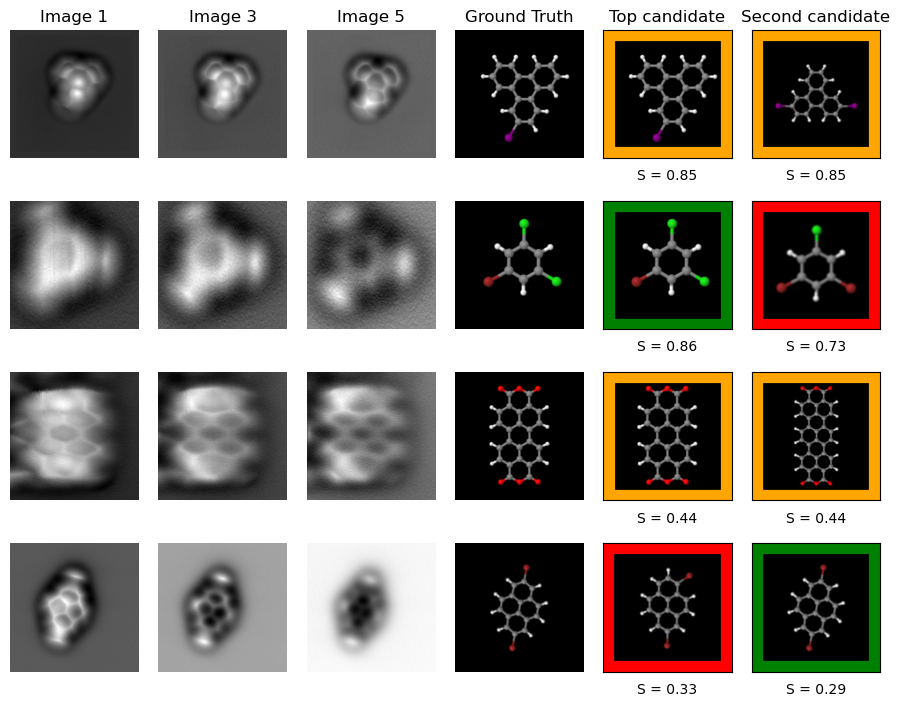

In [10]:
### Add all molecules to experimental_df
path = '/aaa'

experimental_df = test_df
CID = 88955426
SMILES = 'C1=CC=C2C(=C1)C3=C(C=C(C=C3)I)C4=CC=CC=C24'
morgan_fp = morgan_fp_gen(SMILES, nBits=1024)
split='test'
corrugation = np.nan



experimental_df = experimental_df.append({'path':path,
                           'CID':CID, 
                           'SMILES':SMILES,
                           'morgan_fp':morgan_fp,
                           'split':split,
                           'corrugation':corrugation
                            }, ignore_index=True)
'29766 is included in the quam-afm dataset'
##CID = 29766
##SMILES = 'C1=C(C=C(C=C1Cl)Br)Cl'
##morgan_fp = morgan_fp_gen(SMILES, nBits=1024)
##split='test'
##corrugation = np.nan
##
##
##
##experimental_df = experimental_df.append({'path':path,
##                           'CID':CID, 
##                           'SMILES':SMILES,
##                           'morgan_fp':morgan_fp,
##                           'split':split,
##                           'corrugation':corrugation
##                            }, ignore_index=True)

CID = 67191
SMILES = 'C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C(=O)OC7=O)C(=O)OC2=O'
morgan_fp = morgan_fp_gen(SMILES, nBits=1024)
split='test'
corrugation = np.nan



experimental_df = experimental_df.append({'path':path,
                           'CID':CID, 
                           'SMILES':SMILES,
                           'morgan_fp':morgan_fp,
                           'split':split,
                           'corrugation':corrugation
                            }, ignore_index=True)


index_1 = experimental_df[experimental_df['CID'] == 130412167].index[0]
index_2 = experimental_df[experimental_df['CID'] == 88955426].index[0]
#experimental_df[experimental_df['CID'] == 130412167].set_index(index_2)
#experimental_df[experimental_df['CID'] == 88955426].index(index_1)



n_results = 4
fig, ax = plt.subplots(n_results, 6, figsize=(9, n_results*1.8))  # Adjust figsize according to your needs

path_list = [f'/home/{USER}/EXPERIMENTAL_IMAGES/RAW/2-Iodotriphenylene_88955426',
             f'/home/{USER}/EXPERIMENTAL_IMAGES/RAW/1-Bromo-3,5-dichlorobenzene',
             f'/home/{USER}/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA',
             ]
zoom_list = [0.9, 1.4, 1]
jmol_zoom_list = [1, 1.3, 1]

CID_list = [88955426, 29766, 67191]
second_cid_list = [130412167, 84676, 59464606]
jmol_paths = ['/home/mgonzalez/EXPERIMENTAL_IMAGES/jmol_images/2-iodotriphenylene.jpg',
    '/home/mgonzalez/EXPERIMENTAL_IMAGES/jmol_images/1-bromo-3,5-dichlorobenzene.jpg',
    '/home/mgonzalez/EXPERIMENTAL_IMAGES/jmol_images/PTCDA.jpg']

titles = ['Image 1', 'Image 3', 'Image 5', 'Ground Truth', 'Top candidate', 'Second candidate']
for i, path in enumerate(path_list):
    gt_jmol = load_jmol(jmol_paths[i], zoom=jmol_zoom_list[i])
    pred_jmol = load_jmol(jmol_paths[i], zoom=jmol_zoom_list[i])

    exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=zoom_list[i], interpolation='bilinear')
    with torch.no_grad():
        batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
        predictions = model(batched_tensor)
        fp_pred = (torch.sigmoid(predictions) > 0.5)

    exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()
    output_df = fp_screening_function(exp_fp, experimental_df, top_k = 20)
    tanimoto = output_df.iloc[0]['tanimoto']
    tanimoto_second = output_df.iloc[1]['tanimoto']
    print('Is the correct CID in the top k candidates?',  CID_list[i] in list(output_df['CID']))
    print(f"First candidate: {output_df.iloc[0]['CID']}, second candidate: {output_df.iloc[1]['CID']}")
   ## print('----------------------')
   ## print(output_df.iloc[0:5])
   ## print('======================')

    cid_second = second_cid_list[i]
    if i == 1:
        pred_second_jmol = load_jmol_image(cid_second, dimension=[224,224], zoom=0.5)
    
    elif i == 2:
        pred_second_jmol = load_jmol_image(cid_second, dimension=[224,224], zoom=1)
        pred_second_jmol = rotate_image(pred_second_jmol, angle=90)
    else:
        pred_second_jmol = load_jmol_image(cid_second, dimension=[224,224], zoom=0.9)
    
    ax[i,0].imshow(exp_img[1], cmap='gray')
    ax[i,0].axis('off')
    ax[i,1].imshow(exp_img[3], cmap='gray')
    ax[i,1].axis('off')
    ax[i,2].imshow(exp_img[5], cmap='gray')
    ax[i,2].axis('off')
    ax[i,3].imshow(gt_jmol)
    ax[i,3].axis('off')
    ax[i,4].imshow(pred_jmol)
    ax[i,5].imshow(pred_second_jmol)


    
    color = 'green'
    green_rect = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')

    color = 'red'
    red_rect = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
    
    color = 'orange'
    yellow_rect1 = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
    yellow_rect2 = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
    
    
    ax[i,4].set_xticks([])
    ax[i,4].set_yticks([])
    ax[i,4].set_xlabel(f'S = {tanimoto:.2f}', fontsize=10)  # Adjust fontsize according to your needs
    

    ax[i,5].set_xticks([])
    ax[i,5].set_yticks([])
    ax[i,5].set_xlabel(f'S = {tanimoto_second:.2f}', fontsize=10)  # Adjust fontsize according to your needs
    
    if ((i == 0)|(i ==2)):
        
        ax[i,4].add_patch(yellow_rect1)
        ax[i,5].add_patch(yellow_rect2)
    if i==1:
        ax[i,4].add_patch(green_rect)
        ax[i,5].add_patch(red_rect)
    
    # Setting titles for each column
    if i == 0:
        for j in range(6):
            ax[i,j].set_title(titles[j])

####################################### 

"""Last experimental molecule, since it is a mistake we compute it separately"""


path = f'/home/{USER}/EXPERIMENTAL_IMAGES/RAW/2,7-Dibromopyrene-Cu111/image_stack/stack_further' 
sample_df = test_df
experimental_df = sample_df


exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=1.0, normalize=True)
with torch.no_grad():
    batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
    print(batched_tensor.size())
    predictions = model(batched_tensor)
    print(predictions.size())
    fp_pred = (torch.sigmoid(predictions) > 0.5)
    print(fp_pred.size())

exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()
print(exp_fp.shape)
print(exp_fp.sum())

fp_pred = (torch.sigmoid(predictions) > 0.5)
exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()

output_df = fp_screening_function(exp_fp, experimental_df, top_k = 5)

print('Is the correct CID in the top k candidates?',  CID in list(output_df['CID']))




# Final figure:
n_results=1



    
true_CID = 13615479

img_1, img_3, img_5 = exp_img[1], exp_img[3], exp_img[5]

gt_jmol = load_jmol_image(true_CID, dimension=[224,224], zoom=0.7)

pred_CID, second_CID = output_df.iloc[0:2]['CID']
tanimoto, tanimoto_second = output_df.iloc[0:2]['tanimoto']
print(pred_CID, second_CID)

pred_jmol = load_jmol_image(pred_CID, dimension=[224,224], zoom=0.7)
second_jmol = load_jmol_image(second_CID, dimension=[224,224], zoom=0.7)

# rotation 
rot_gt_jmol = rotate_image(gt_jmol, angle=80)
pred_jmol = rotate_image(pred_jmol, angle=80)
second_jmol = rotate_image(second_jmol, angle=80)


ax[3,0].imshow(img_1, cmap='gray')
ax[3,0].axis('off')
ax[3,1].imshow(img_3, cmap='gray')
ax[3,1].axis('off')
ax[3,2].imshow(img_5, cmap='gray')
ax[3,2].axis('off')
ax[3,3].imshow(rot_gt_jmol)
ax[3,3].axis('off')
ax[3,4].imshow(pred_jmol)
ax[3,5].imshow(second_jmol)



color = 'green'
green_rect = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')

color = 'red'
red_rect = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')

ax[3,4].add_patch(red_rect)
ax[3,4].set_xticks([])
ax[3,4].set_yticks([])
ax[3,4].set_xlabel(f'S = {tanimoto:.2f}', fontsize=10)  # Adjust fontsize according to your needs

ax[3,5].add_patch(green_rect)
ax[3,5].set_xticks([])
ax[3,5].set_yticks([])
ax[3,5].set_xlabel(f'S = {tanimoto_second:.2f}', fontsize=10)  # Adjust fontsize according to your needs



#######################################

plt.tight_layout()
plt.savefig('experimental_identification_4_molecules_second_candidates_v2.pdf', dpi=500, format='pdf', quality=120, optimize=True)

plt.show()




/tmp/ipykernel_448816/1166241640.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  experimental_df = experimental_df.append({'path':path,
/tmp/ipykernel_448816/1166241640.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  experimental_df = experimental_df.append({'path':path,


Is the correct CID in the top k candidates? True
First candidate: 29766, second candidate: 84676
Is the correct CID in the top k candidates? True
First candidate: 130412167, second candidate: 88955426
Is the correct CID in the top k candidates? True
First candidate: 67191, second candidate: 59464606
torch.Size([1, 10, 224, 224])
torch.Size([1, 1024])
torch.Size([1, 1024])
(1024,)
30
Is the correct CID in the top k candidates? False
23073216 13615479


/tmp/ipykernel_448816/1166241640.py:246: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('experimental_identification_4_molecules_second_candidates_v4.pdf', dpi=500, format='pdf', quality=120, optimize=True)
/tmp/ipykernel_448816/1166241640.py:246: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "optimize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('experimental_identification_4_molecules_second_candidates_v4.pdf', dpi=500, format='pdf', quality=120, optimize=True)


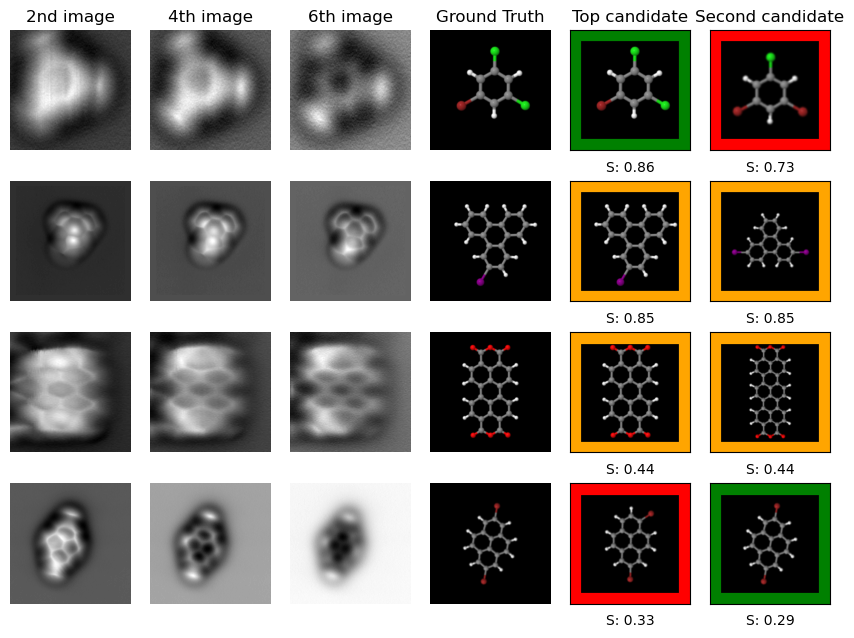

In [10]:
### Add all molecules to experimental_df
path = '/aaa'

experimental_df = test_df
CID = 88955426
SMILES = 'C1=CC=C2C(=C1)C3=C(C=C(C=C3)I)C4=CC=CC=C24'
morgan_fp = morgan_fp_gen(SMILES, nBits=1024)
split='test'
corrugation = np.nan



experimental_df = experimental_df.append({'path':path,
                           'CID':CID, 
                           'SMILES':SMILES,
                           'morgan_fp':morgan_fp,
                           'split':split,
                           'corrugation':corrugation
                            }, ignore_index=True)
'29766 is included in the quam-afm dataset'
##CID = 29766
##SMILES = 'C1=C(C=C(C=C1Cl)Br)Cl'
##morgan_fp = morgan_fp_gen(SMILES, nBits=1024)
##split='test'
##corrugation = np.nan
##
##
##
##experimental_df = experimental_df.append({'path':path,
##                           'CID':CID, 
##                           'SMILES':SMILES,
##                           'morgan_fp':morgan_fp,
##                           'split':split,
##                           'corrugation':corrugation
##                            }, ignore_index=True)

CID = 67191
SMILES = 'C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C(=O)OC7=O)C(=O)OC2=O'
morgan_fp = morgan_fp_gen(SMILES, nBits=1024)
split='test'
corrugation = np.nan



experimental_df = experimental_df.append({'path':path,
                           'CID':CID, 
                           'SMILES':SMILES,
                           'morgan_fp':morgan_fp,
                           'split':split,
                           'corrugation':corrugation
                            }, ignore_index=True)


index_1 = experimental_df[experimental_df['CID'] == 130412167].index[0]
index_2 = experimental_df[experimental_df['CID'] == 88955426].index[0]
#experimental_df[experimental_df['CID'] == 130412167].set_index(index_2)
#experimental_df[experimental_df['CID'] == 88955426].index(index_1)



n_results = 4
fig, ax = plt.subplots(n_results, 6, figsize=(8.5, n_results*1.6))  # Adjust figsize according to your needs

path_list = [f'/home/{USER}/EXPERIMENTAL_IMAGES/RAW/1-Bromo-3,5-dichlorobenzene',
             f'/home/{USER}/EXPERIMENTAL_IMAGES/RAW/2-Iodotriphenylene_88955426',
             f'/home/{USER}/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA',
             ]
zoom_list = [1.4, 0.9 , 1]
jmol_zoom_list = [1.3, 1,  1]

CID_list = [29766, 88955426, 67191]
second_cid_list = [84676, 130412167, 59464606]
jmol_paths = ['/home/mgonzalez/EXPERIMENTAL_IMAGES/jmol_images/1-bromo-3,5-dichlorobenzene.jpg',
    '/home/mgonzalez/EXPERIMENTAL_IMAGES/jmol_images/2-iodotriphenylene.jpg',
    '/home/mgonzalez/EXPERIMENTAL_IMAGES/jmol_images/PTCDA.jpg']

titles = ['2nd image', '4th image', '6th image', 'Ground Truth', 'Top candidate', 'Second candidate']
for i, path in enumerate(path_list):
    gt_jmol = load_jmol(jmol_paths[i], zoom=jmol_zoom_list[i])
    pred_jmol = load_jmol(jmol_paths[i], zoom=jmol_zoom_list[i])

    exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=zoom_list[i], interpolation='bilinear')
    with torch.no_grad():
        batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
        predictions = model(batched_tensor)
        fp_pred = (torch.sigmoid(predictions) > 0.5)

    exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()
    output_df = fp_screening_function(exp_fp, experimental_df, top_k = 20)
    tanimoto = output_df.iloc[0]['tanimoto']
    tanimoto_second = output_df.iloc[1]['tanimoto']
    print('Is the correct CID in the top k candidates?',  CID_list[i] in list(output_df['CID']))
    print(f"First candidate: {output_df.iloc[0]['CID']}, second candidate: {output_df.iloc[1]['CID']}")
   ## print('----------------------')
   ## print(output_df.iloc[0:5])
   ## print('======================')

    cid_second = second_cid_list[i]
    if i == 0:
        pred_second_jmol = load_jmol_image(cid_second, dimension=[224,224], zoom=0.5)
    
    elif i == 2:
        pred_second_jmol = load_jmol_image(cid_second, dimension=[224,224], zoom=1)
        pred_second_jmol = rotate_image(pred_second_jmol, angle=90)
    else:
        pred_second_jmol = load_jmol_image(cid_second, dimension=[224,224], zoom=0.9)
    
    ax[i,0].imshow(exp_img[1], cmap='gray')
    ax[i,0].axis('off')
    ax[i,1].imshow(exp_img[3], cmap='gray')
    ax[i,1].axis('off')
    ax[i,2].imshow(exp_img[5], cmap='gray')
    ax[i,2].axis('off')
    ax[i,3].imshow(gt_jmol)
    ax[i,3].axis('off')
    ax[i,4].imshow(pred_jmol)
    ax[i,5].imshow(pred_second_jmol)


    
    color = 'green'
    green_rect = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')

    color = 'red'
    red_rect = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
    
    color = 'orange'
    yellow_rect1 = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
    yellow_rect2 = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
    
    
    ax[i,4].set_xticks([])
    ax[i,4].set_yticks([])
    ax[i,4].set_xlabel(f'S: {tanimoto:.2f}', fontsize=10)  # Adjust fontsize according to your needs
    

    ax[i,5].set_xticks([])
    ax[i,5].set_yticks([])
    ax[i,5].set_xlabel(f'S: {tanimoto_second:.2f}', fontsize=10)  # Adjust fontsize according to your needs
    
    if ((i == 1)|(i ==2)):
        
        ax[i,4].add_patch(yellow_rect1)
        ax[i,5].add_patch(yellow_rect2)
    if i==0:
        ax[i,4].add_patch(green_rect)
        ax[i,5].add_patch(red_rect)
    
    # Setting titles for each column
    if i == 0:
        for j in range(6):
            ax[i,j].set_title(titles[j])

####################################### 

"""Last experimental molecule, since it is a mistake we compute it separately"""


path = f'/home/{USER}/EXPERIMENTAL_IMAGES/RAW/2,7-Dibromopyrene-Cu111/image_stack/stack_further' 
sample_df = test_df
experimental_df = sample_df


exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=1.0, normalize=True)
with torch.no_grad():
    batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
    print(batched_tensor.size())
    predictions = model(batched_tensor)
    print(predictions.size())
    fp_pred = (torch.sigmoid(predictions) > 0.5)
    print(fp_pred.size())

exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()
print(exp_fp.shape)
print(exp_fp.sum())

fp_pred = (torch.sigmoid(predictions) > 0.5)
exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()

output_df = fp_screening_function(exp_fp, experimental_df, top_k = 5)

print('Is the correct CID in the top k candidates?',  CID in list(output_df['CID']))




# Final figure:
n_results=1



    
true_CID = 13615479

img_1, img_3, img_5 = exp_img[1], exp_img[3], exp_img[5]

gt_jmol = load_jmol_image(true_CID, dimension=[224,224], zoom=0.7)

pred_CID, second_CID = output_df.iloc[0:2]['CID']
tanimoto, tanimoto_second = output_df.iloc[0:2]['tanimoto']
print(pred_CID, second_CID)

pred_jmol = load_jmol_image(pred_CID, dimension=[224,224], zoom=0.7)
second_jmol = load_jmol_image(second_CID, dimension=[224,224], zoom=0.7)

# rotation 
rot_gt_jmol = rotate_image(gt_jmol, angle=80)
pred_jmol = rotate_image(pred_jmol, angle=80)
second_jmol = rotate_image(second_jmol, angle=80)


ax[3,0].imshow(img_1, cmap='gray')
ax[3,0].axis('off')
ax[3,1].imshow(img_3, cmap='gray')
ax[3,1].axis('off')
ax[3,2].imshow(img_5, cmap='gray')
ax[3,2].axis('off')
ax[3,3].imshow(rot_gt_jmol)
ax[3,3].axis('off')
ax[3,4].imshow(pred_jmol)
ax[3,5].imshow(second_jmol)



color = 'green'
green_rect = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')

color = 'red'
red_rect = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')

ax[3,4].add_patch(red_rect)
ax[3,4].set_xticks([])
ax[3,4].set_yticks([])
ax[3,4].set_xlabel(f'S: {tanimoto:.2f}', fontsize=10)  # Adjust fontsize according to your needs

ax[3,5].add_patch(green_rect)
ax[3,5].set_xticks([])
ax[3,5].set_yticks([])
ax[3,5].set_xlabel(f'S: {tanimoto_second:.2f}', fontsize=10)  # Adjust fontsize according to your needs



#######################################

plt.tight_layout()
plt.savefig('experimental_identification_4_molecules_second_candidates_v4.pdf', dpi=500, format='pdf', quality=120, optimize=True)

plt.show()




# Check regression chemical formula

In [32]:
from utils.models import resnet_10_chan, effnet_10_chan, eff_net_bias_warmer, regressor_from_checkpoint, \
                            AtomCountPredictor


# Load data

data_path = f'/home/{USER}/QUAM-AFM/datasets/atoms_count_df.gz'
dataset_df = pd.read_pickle(data_path)

test_df = dataset_df[dataset_df['split'] == 'test']


print('Test set samples:', len(testset))





# model and metrics initialization
criterion = nn.MSELoss()


models_path = f'/home/{USER}/CODE/Pytorch-fingerprints/experiments/regression_w_H/models'
checkpoint_path = os.path.join(models_path, 'checkpoint_2_virtual_epoch_1.pth')

pretrained_model = effnet_10_chan(output_size=args.n_fp, dropout=args.dropout)
model = AtomCountPredictor(pretrained_model, output_size=args.output_size).to(device)

checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

data_path = f'/home/{USER}/QUAM-AFM/datasets/atoms_count_w_H_df.gz'
dataset_df = pd.read_pickle(data_path)

print('Finished')

Test set samples: 279905
Finished


### 2-iodotriphenylene

In [60]:
test_df = dataset_df[dataset_df['split']=='test']
sample_df = test_df

In [61]:
path = f'/home/{USER}/EXPERIMENTAL_IMAGES/RAW/2-Iodotriphenylene_88955426'
sorted(glob.glob(os.path.join(path,'*')))

['/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2-Iodotriphenylene_88955426/z058_1.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2-Iodotriphenylene_88955426/z066_2.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2-Iodotriphenylene_88955426/z074_3.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2-Iodotriphenylene_88955426/z082_4.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2-Iodotriphenylene_88955426/z090_5.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2-Iodotriphenylene_88955426/z098_6.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2-Iodotriphenylene_88955426/z106_7.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2-Iodotriphenylene_88955426/z114_8.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2-Iodotriphenylene_88955426/z122_9.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2-Iodotriphenylene_88955426/z130_10.jpg']

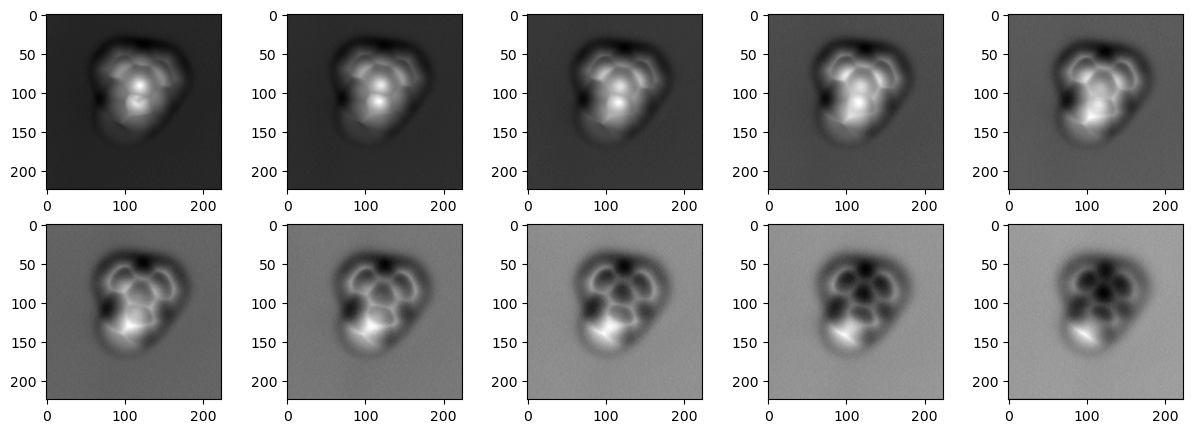

In [62]:
exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=1)
#10 images
f, axarr = plt.subplots(2,5, figsize=(15, 5))
axarr[0,0].imshow(exp_img[0], cmap = 'gray')
axarr[0,1].imshow(exp_img[1], cmap = 'gray')
axarr[0,2].imshow(exp_img[2], cmap = 'gray')
axarr[0,3].imshow(exp_img[3], cmap = 'gray')
axarr[0,4].imshow(exp_img[4], cmap = 'gray')
axarr[1,0].imshow(exp_img[5], cmap = 'gray')
axarr[1,1].imshow(exp_img[6], cmap = 'gray')
axarr[1,2].imshow(exp_img[7], cmap = 'gray')
axarr[1,3].imshow(exp_img[8], cmap = 'gray')
axarr[1,4].imshow(exp_img[9], cmap = 'gray')

In [63]:
sample_df

CID   C  Br  Cl  F  I  N  O  P  S   H split  \
1        10001048  25   0   0  0  0  6  0  0  0  16  test   
7           10005   2   0   0  0  0  4  0  0  0   4  test   
14      100128716  15   0   0  0  0  3  0  0  0  21  test   
15      100175925  10   0   0  0  0  3  4  0  2   9  test   
16      100197007  18   0   0  0  0  3  4  0  2  13  test   
...           ...  ..  ..  .. .. .. .. .. .. ..  ..   ...   
579897   13762891  16   0   0  0  0  2  6  0  0  12  test   
579900     341027  11   0   0  0  0  0  5  0  0   6  test   
579902   53921077   7   0   0  0  0  2  0  0  0   8  test   
579903   82382131  14   0   0  0  0  3  2  0  0  11  test   
579904   82418146   5   0   0  0  0  1  4  0  0   3  test   

                                                     path  
1       /scratch/dataset/quam/K-1/Conformer3D_CID_1000...  
7       /scratch/dataset/quam/K-1/Conformer3D_CID_1000...  
14      /scratch/dataset/quam/K-1/Conformer3D_CID_1001...  
15      /scratch/dataset/quam/K-1/Conformer3D_CID_1001...  
16      /scratch/dataset/quam/K-1/Conformer3D_CID_1001...  
...                                                   ...  
579897  /scratch/dataset/quam/K-1/Conformer3D_CID_1376...  
579900  /scratch/dataset/quam/K-1/Conformer3D_CID_3410...  
579902  /scratch/dataset/quam/K-1/Conformer3D_CID_5392...  
579903  /scratch/dataset/quam/K-1/Conformer3D_CID_8238...  
579904  /scratch/dataset/quam/K-1/Conformer3D_CID_8241...  

[279848 rows x 13 columns]

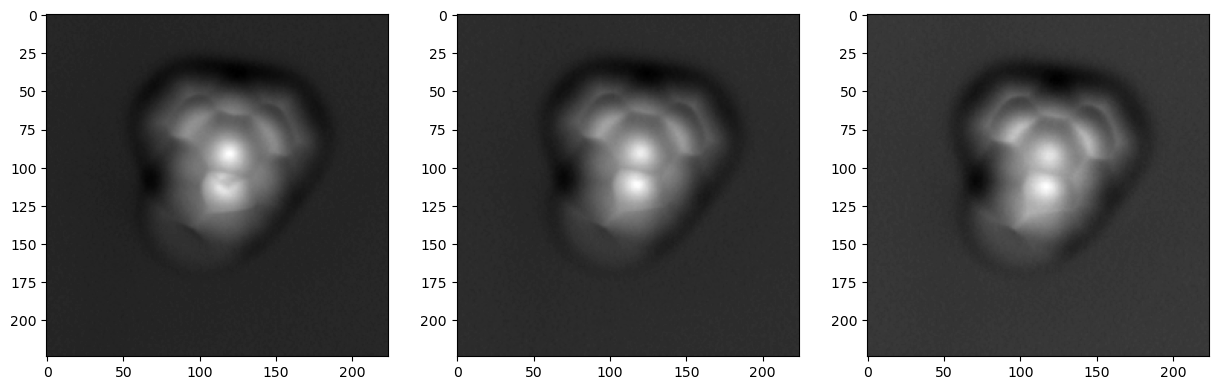

In [64]:
# 3 images

f, axarr = plt.subplots(1,3, figsize=(15, 5))
axarr[0].imshow(exp_img[0], cmap = 'gray')
axarr[1].imshow(exp_img[1], cmap = 'gray')
axarr[2].imshow(exp_img[2], cmap = 'gray')


In [65]:
#the CID was in neither train nor test so we added it, now it is here.

In [66]:

CID = 88955426
SMILES = 'C1=CC=C2C(=C1)C3=C(C=C(C=C3)I)C4=CC=CC=C24'
morgan_fp = morgan_fp_gen(SMILES, nBits=1024)
split='test'
corrugation = np.nan



experimental_df = sample_df.append({'path':path,
                           'CID':CID, 
                           'SMILES':SMILES,
                           'morgan_fp':morgan_fp,
                           'split':split,
                           'corrugation':corrugation,
                           'C':18,
                           'Br':0,
                           'Cl':0,
                           'F':0,
                           'I':1,
                           'N':0,
                           'O':0,
                           'P':0,
                           'S':0,
                           'H':11,

                                    
                            }
                                   , ignore_index=True)
experimental_df

/tmp/ipykernel_128139/1975320609.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  experimental_df = sample_df.append({'path':path,


CID   C  Br  Cl  F  I  N  O  P  S   H split  \
0        10001048  25   0   0  0  0  6  0  0  0  16  test   
1           10005   2   0   0  0  0  4  0  0  0   4  test   
2       100128716  15   0   0  0  0  3  0  0  0  21  test   
3       100175925  10   0   0  0  0  3  4  0  2   9  test   
4       100197007  18   0   0  0  0  3  4  0  2  13  test   
...           ...  ..  ..  .. .. .. .. .. .. ..  ..   ...   
279844     341027  11   0   0  0  0  0  5  0  0   6  test   
279845   53921077   7   0   0  0  0  2  0  0  0   8  test   
279846   82382131  14   0   0  0  0  3  2  0  0  11  test   
279847   82418146   5   0   0  0  0  1  4  0  0   3  test   
279848   88955426  18   0   0  0  1  0  0  0  0  11  test   

                                                     path  \
0       /scratch/dataset/quam/K-1/Conformer3D_CID_1000...   
1       /scratch/dataset/quam/K-1/Conformer3D_CID_1000...   
2       /scratch/dataset/quam/K-1/Conformer3D_CID_1001...   
3       /scratch/dataset/quam/K-1/Conformer3D_CID_1001...   
4       /scratch/dataset/quam/K-1/Conformer3D_CID_1001...   
...                                                   ...   
279844  /scratch/dataset/quam/K-1/Conformer3D_CID_3410...   
279845  /scratch/dataset/quam/K-1/Conformer3D_CID_5392...   
279846  /scratch/dataset/quam/K-1/Conformer3D_CID_8238...   
279847  /scratch/dataset/quam/K-1/Conformer3D_CID_8241...   
279848  /home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2-Iodo...   

                                            SMILES  corrugation  \
0                                              NaN          NaN   
1                                              NaN          NaN   
2                                              NaN          NaN   
3                                              NaN          NaN   
4                                              NaN          NaN   
...                                            ...          ...   
279844                                         NaN          NaN   
279845                                         NaN          NaN   
279846                                         NaN          NaN   
279847                                         NaN          NaN   
279848  C1=CC=C2C(=C1)C3=C(C=C(C=C3)I)C4=CC=CC=C24          NaN   

                                                morgan_fp  
0                                                     NaN  
1                                                     NaN  
2                                                     NaN  
3                                                     NaN  
4                                                     NaN  
...                                                   ...  
279844                                                NaN  
279845                                                NaN  
279846                                                NaN  
279847                                                NaN  
279848  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  

[279849 rows x 16 columns]

In [68]:
experimental_df[experimental_df['path'] == path]

CID   C  Br  Cl  F  I  N  O  P  S   H split  \
279848  88955426  18   0   0  0  1  0  0  0  0  11  test   

                                                     path  \
279848  /home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2-Iodo...   

                                            SMILES  corrugation  \
279848  C1=CC=C2C(=C1)C3=C(C=C(C=C3)I)C4=CC=CC=C24          NaN   

                                                morgan_fp  
279848  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [69]:
exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=1)
with torch.no_grad():
    batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
    print(batched_tensor.size())
    predictions = model(batched_tensor)
    print(predictions.size())
    atom_count = torch.round(predictions) 
    print(atom_count.size())

atom_count = atom_count.cpu().numpy().astype(int).squeeze()
for atom, count in zip(['C', 'Br', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S', 'H'], atom_count):
    print(atom, ':', count)
print(f'Total atoms: {atom_count.sum()}')

torch.Size([1, 10, 224, 224])
torch.Size([10])
torch.Size([10])
C : 19
Br : 0
Cl : 0
F : 0
I : 0
N : 0
O : 0
P : 0
S : 0
H : 11
Total atoms: 30


In [44]:
gt_arr = np.array(experimental_df[experimental_df['path'] == path][['C','Br','Cl','F','I','N','O','P','S','H']]).squeeze()
gt_arr

array([18,  0,  0,  0,  1,  0,  0,  0,  0, 11])

In [45]:
def mae_loss(predictions, gt_arr):
    return np.sum(np.abs(predictions-gt_arr))
mae_loss(predictions, gt_arr)

2

In [46]:
for interpolation_method in ['bilinear', 'nearest', 'bicubic']:
    print(f'Interpolation method: {interpolation_method}')
    for zoom in [ 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]:
        exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=zoom, interpolation=interpolation_method)
        with torch.no_grad():
            batched_tensor = exp_img.unsqueeze(dim = 0).to(device)

            predictions = torch.round(model(batched_tensor))

            


        predictions = predictions.cpu().numpy().astype(int)

        
        
        print('zoom:', zoom, 'mae loss', mae_loss(predictions, gt_arr))


Interpolation method: bilinear
zoom: 0.5 mae loss 20
zoom: 0.6 mae loss 10
zoom: 0.7 mae loss 6
zoom: 0.8 mae loss 2
zoom: 0.9 mae loss 2
zoom: 1 mae loss 2
zoom: 1.1 mae loss 3
zoom: 1.2 mae loss 3
zoom: 1.3 mae loss 3
zoom: 1.4 mae loss 8
zoom: 1.5 mae loss 11
Interpolation method: nearest
zoom: 0.5 mae loss 20
zoom: 0.6 mae loss 12
zoom: 0.7 mae loss 6
zoom: 0.8 mae loss 1
zoom: 0.9 mae loss 3
zoom: 1 mae loss 2
zoom: 1.1 mae loss 5
zoom: 1.2 mae loss 5
zoom: 1.3 mae loss 4
zoom: 1.4 mae loss 9
zoom: 1.5 mae loss 12
Interpolation method: bicubic
zoom: 0.5 mae loss 21
zoom: 0.6 mae loss 9
zoom: 0.7 mae loss 6
zoom: 0.8 mae loss 2
zoom: 0.9 mae loss 2
zoom: 1 mae loss 2
zoom: 1.1 mae loss 3
zoom: 1.2 mae loss 3
zoom: 1.3 mae loss 3
zoom: 1.4 mae loss 9
zoom: 1.5 mae loss 12


### BCB: 1-Bromo-3,5-dichlorobenzene
https://pubchem.ncbi.nlm.nih.gov/compound/29766

In [91]:
path = f'/home/{USER}/EXPERIMENTAL_IMAGES/RAW/1-Bromo-3,5-dichlorobenzene' 

sample_df = test_df
sorted(glob.glob(os.path.join(path,'*')))

['/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/1-Bromo-3,5-dichlorobenzene/image_0.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/1-Bromo-3,5-dichlorobenzene/image_1.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/1-Bromo-3,5-dichlorobenzene/image_2.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/1-Bromo-3,5-dichlorobenzene/image_3.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/1-Bromo-3,5-dichlorobenzene/image_4.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/1-Bromo-3,5-dichlorobenzene/image_5.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/1-Bromo-3,5-dichlorobenzene/image_6.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/1-Bromo-3,5-dichlorobenzene/image_7.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/1-Bromo-3,5-dichlorobenzene/image_8.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/1-Bromo-3,5-dichlorobenzene/image_9.jpg']

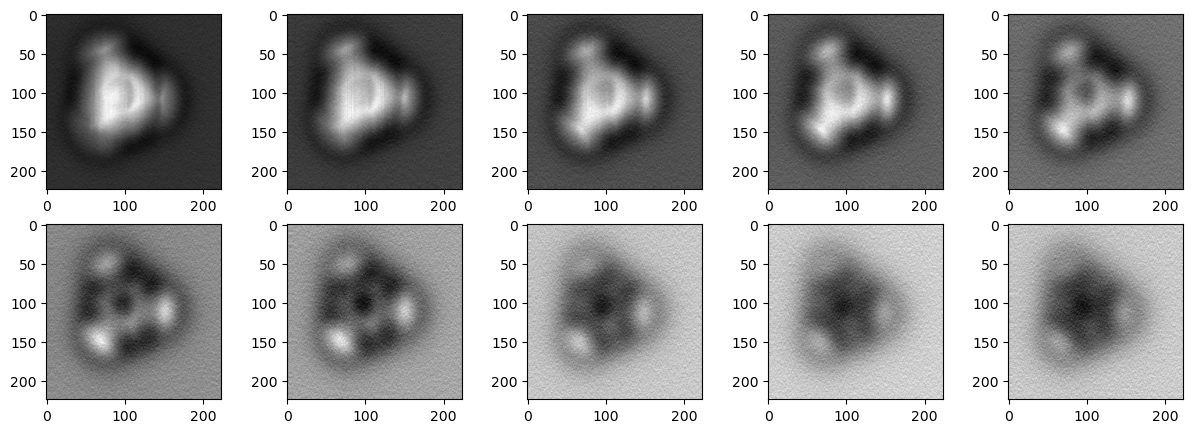

In [92]:
exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=1)
#10 images
f, axarr = plt.subplots(2,5, figsize=(15, 5))
axarr[0,0].imshow(exp_img[0], cmap = 'gray')
axarr[0,1].imshow(exp_img[1], cmap = 'gray')
axarr[0,2].imshow(exp_img[2], cmap = 'gray')
axarr[0,3].imshow(exp_img[3], cmap = 'gray')
axarr[0,4].imshow(exp_img[4], cmap = 'gray')
axarr[1,0].imshow(exp_img[5], cmap = 'gray')
axarr[1,1].imshow(exp_img[6], cmap = 'gray')
axarr[1,2].imshow(exp_img[7], cmap = 'gray')
axarr[1,3].imshow(exp_img[8], cmap = 'gray')
axarr[1,4].imshow(exp_img[9], cmap = 'gray')

In [93]:
sample_df

CID   C  Br  Cl  F  I  N  O  P  S   H split  \
1        10001048  25   0   0  0  0  6  0  0  0  16  test   
7           10005   2   0   0  0  0  4  0  0  0   4  test   
14      100128716  15   0   0  0  0  3  0  0  0  21  test   
15      100175925  10   0   0  0  0  3  4  0  2   9  test   
16      100197007  18   0   0  0  0  3  4  0  2  13  test   
...           ...  ..  ..  .. .. .. .. .. .. ..  ..   ...   
579897   13762891  16   0   0  0  0  2  6  0  0  12  test   
579900     341027  11   0   0  0  0  0  5  0  0   6  test   
579902   53921077   7   0   0  0  0  2  0  0  0   8  test   
579903   82382131  14   0   0  0  0  3  2  0  0  11  test   
579904   82418146   5   0   0  0  0  1  4  0  0   3  test   

                                                     path  
1       /scratch/dataset/quam/K-1/Conformer3D_CID_1000...  
7       /scratch/dataset/quam/K-1/Conformer3D_CID_1000...  
14      /scratch/dataset/quam/K-1/Conformer3D_CID_1001...  
15      /scratch/dataset/quam/K-1/Conformer3D_CID_1001...  
16      /scratch/dataset/quam/K-1/Conformer3D_CID_1001...  
...                                                   ...  
579897  /scratch/dataset/quam/K-1/Conformer3D_CID_1376...  
579900  /scratch/dataset/quam/K-1/Conformer3D_CID_3410...  
579902  /scratch/dataset/quam/K-1/Conformer3D_CID_5392...  
579903  /scratch/dataset/quam/K-1/Conformer3D_CID_8238...  
579904  /scratch/dataset/quam/K-1/Conformer3D_CID_8241...  

[279848 rows x 13 columns]

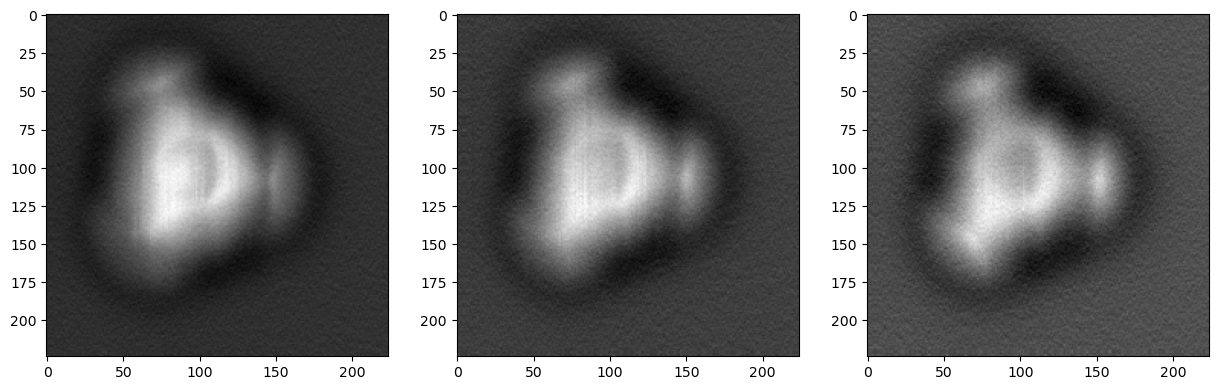

In [94]:
# 3 images

f, axarr = plt.subplots(1,3, figsize=(15, 5))
axarr[0].imshow(exp_img[0], cmap = 'gray')
axarr[1].imshow(exp_img[1], cmap = 'gray')
axarr[2].imshow(exp_img[2], cmap = 'gray')


In [95]:
#the CID was in neither train nor test so we added it, now it is here.

In [96]:

CID = 29766
SMILES = 'C1=C(C=C(C=C1Cl)Br)Cl'
morgan_fp = morgan_fp_gen(SMILES, nBits=1024)
split='test'
corrugation = np.nan



experimental_df = sample_df.append({'path':path,
                           'CID':CID, 
                           'SMILES':SMILES,
                           'morgan_fp':morgan_fp,
                           'split':split,
                           'corrugation':corrugation,
                           'C':6,
                           'Br':1,
                           'Cl':2,
                           'F':0,
                           'I':0,
                           'N':0,
                           'O':0,
                           'P':0,
                           'S':0,
                           'H':3,

                                    
                            }
                                   , ignore_index=True)
experimental_df

/tmp/ipykernel_128139/1557459969.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  experimental_df = sample_df.append({'path':path,


CID   C  Br  Cl  F  I  N  O  P  S   H split  \
0        10001048  25   0   0  0  0  6  0  0  0  16  test   
1           10005   2   0   0  0  0  4  0  0  0   4  test   
2       100128716  15   0   0  0  0  3  0  0  0  21  test   
3       100175925  10   0   0  0  0  3  4  0  2   9  test   
4       100197007  18   0   0  0  0  3  4  0  2  13  test   
...           ...  ..  ..  .. .. .. .. .. .. ..  ..   ...   
279844     341027  11   0   0  0  0  0  5  0  0   6  test   
279845   53921077   7   0   0  0  0  2  0  0  0   8  test   
279846   82382131  14   0   0  0  0  3  2  0  0  11  test   
279847   82418146   5   0   0  0  0  1  4  0  0   3  test   
279848      29766   6   1   2  0  0  0  0  0  0   3  test   

                                                     path  \
0       /scratch/dataset/quam/K-1/Conformer3D_CID_1000...   
1       /scratch/dataset/quam/K-1/Conformer3D_CID_1000...   
2       /scratch/dataset/quam/K-1/Conformer3D_CID_1001...   
3       /scratch/dataset/quam/K-1/Conformer3D_CID_1001...   
4       /scratch/dataset/quam/K-1/Conformer3D_CID_1001...   
...                                                   ...   
279844  /scratch/dataset/quam/K-1/Conformer3D_CID_3410...   
279845  /scratch/dataset/quam/K-1/Conformer3D_CID_5392...   
279846  /scratch/dataset/quam/K-1/Conformer3D_CID_8238...   
279847  /scratch/dataset/quam/K-1/Conformer3D_CID_8241...   
279848  /home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/1-Brom...   

                       SMILES  corrugation  \
0                         NaN          NaN   
1                         NaN          NaN   
2                         NaN          NaN   
3                         NaN          NaN   
4                         NaN          NaN   
...                       ...          ...   
279844                    NaN          NaN   
279845                    NaN          NaN   
279846                    NaN          NaN   
279847                    NaN          NaN   
279848  C1=C(C=C(C=C1Cl)Br)Cl          NaN   

                                                morgan_fp  
0                                                     NaN  
1                                                     NaN  
2                                                     NaN  
3                                                     NaN  
4                                                     NaN  
...                                                   ...  
279844                                                NaN  
279845                                                NaN  
279846                                                NaN  
279847                                                NaN  
279848  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  

[279849 rows x 16 columns]

In [97]:
experimental_df[experimental_df['path'] == path]

CID  C  Br  Cl  F  I  N  O  P  S  H split  \
279848  29766  6   1   2  0  0  0  0  0  0  3  test   

                                                     path  \
279848  /home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/1-Brom...   

                       SMILES  corrugation  \
279848  C1=C(C=C(C=C1Cl)Br)Cl          NaN   

                                                morgan_fp  
279848  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [98]:
exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=1)
with torch.no_grad():
    batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
    print(batched_tensor.size())
    predictions = model(batched_tensor)
    print(predictions.size())
    atom_count = torch.round(predictions) 
    print(atom_count.size())

atom_count = atom_count.cpu().numpy().astype(int).squeeze()
for atom, count in zip(['C', 'Br', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S', 'H'], atom_count):
    print(atom, ':', count)
print(f'Total atoms: {atom_count.sum()}')

torch.Size([1, 10, 224, 224])
torch.Size([10])
torch.Size([10])
C : 7
Br : 0
Cl : 3
F : 0
I : 0
N : 0
O : 0
P : 0
S : 0
H : 4
Total atoms: 14


In [78]:
gt_arr = np.array(experimental_df[experimental_df['path'] == path][['C','Br','Cl','F','I','N','O','P','S','H']]).squeeze()
gt_arr

array([6, 1, 2, 0, 0, 0, 0, 0, 0, 3])

In [99]:
def mae_loss(predictions, gt_arr):
    return np.sum(np.abs(predictions-gt_arr))
mae_loss(predictions, gt_arr)

TypeError: sum() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * (*, torch.dtype dtype)
      didn't match because some of the keywords were incorrect: out, axis
 * (tuple of ints dim, bool keepdim, *, torch.dtype dtype)
 * (tuple of names dim, bool keepdim, *, torch.dtype dtype)


In [82]:
for interpolation_method in ['bilinear', 'nearest', 'bicubic']:
    print(f'Interpolation method: {interpolation_method}')
    for zoom in [ 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]:
        exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=zoom, interpolation=interpolation_method)
        with torch.no_grad():
            batched_tensor = exp_img.unsqueeze(dim = 0).to(device)

            predictions = torch.round(model(batched_tensor))

            


        predictions = predictions.cpu().numpy().astype(int)

        
        
        print('zoom:', zoom, 'mae loss', mae_loss(predictions, gt_arr))


Interpolation method: bilinear
zoom: 0.5 mae loss 8
zoom: 0.6 mae loss 8
zoom: 0.7 mae loss 7
zoom: 0.8 mae loss 7
zoom: 0.9 mae loss 2
zoom: 1 mae loss 4
zoom: 1.1 mae loss 7
zoom: 1.2 mae loss 9
zoom: 1.3 mae loss 10
zoom: 1.4 mae loss 12
zoom: 1.5 mae loss 13
Interpolation method: nearest
zoom: 0.5 mae loss 9
zoom: 0.6 mae loss 7
zoom: 0.7 mae loss 2
zoom: 0.8 mae loss 2
zoom: 0.9 mae loss 2
zoom: 1 mae loss 2
zoom: 1.1 mae loss 3
zoom: 1.2 mae loss 11
zoom: 1.3 mae loss 19
zoom: 1.4 mae loss 20
zoom: 1.5 mae loss 14
Interpolation method: bicubic
zoom: 0.5 mae loss 8
zoom: 0.6 mae loss 5
zoom: 0.7 mae loss 5
zoom: 0.8 mae loss 5
zoom: 0.9 mae loss 0
zoom: 1 mae loss 4
zoom: 1.1 mae loss 8
zoom: 1.2 mae loss 11
zoom: 1.3 mae loss 10
zoom: 1.4 mae loss 11
zoom: 1.5 mae loss 12


### PTCDA: 3,4,9,10-Perylenetetracarboxylic dianhydride
https://pubchem.ncbi.nlm.nih.gov/compound/67191

In [100]:
path = f'/home/{USER}/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA' 
sample_df = test_df
sorted(glob.glob(os.path.join(path,'*')))

['/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA/image_0.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA/image_1.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA/image_2.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA/image_3.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA/image_4.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA/image_5.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA/image_6.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA/image_7.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA/image_8.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA/image_9.jpg']

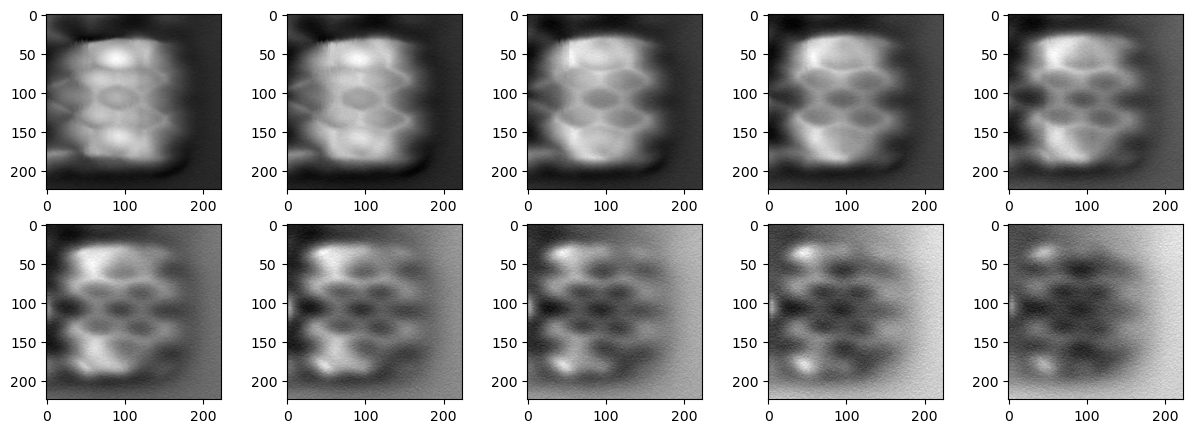

In [101]:
exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=1)
#10 images
f, axarr = plt.subplots(2,5, figsize=(15, 5))
axarr[0,0].imshow(exp_img[0], cmap = 'gray')
axarr[0,1].imshow(exp_img[1], cmap = 'gray')
axarr[0,2].imshow(exp_img[2], cmap = 'gray')
axarr[0,3].imshow(exp_img[3], cmap = 'gray')
axarr[0,4].imshow(exp_img[4], cmap = 'gray')
axarr[1,0].imshow(exp_img[5], cmap = 'gray')
axarr[1,1].imshow(exp_img[6], cmap = 'gray')
axarr[1,2].imshow(exp_img[7], cmap = 'gray')
axarr[1,3].imshow(exp_img[8], cmap = 'gray')
axarr[1,4].imshow(exp_img[9], cmap = 'gray')

In [102]:
sample_df

CID   C  Br  Cl  F  I  N  O  P  S   H split  \
1        10001048  25   0   0  0  0  6  0  0  0  16  test   
7           10005   2   0   0  0  0  4  0  0  0   4  test   
14      100128716  15   0   0  0  0  3  0  0  0  21  test   
15      100175925  10   0   0  0  0  3  4  0  2   9  test   
16      100197007  18   0   0  0  0  3  4  0  2  13  test   
...           ...  ..  ..  .. .. .. .. .. .. ..  ..   ...   
579897   13762891  16   0   0  0  0  2  6  0  0  12  test   
579900     341027  11   0   0  0  0  0  5  0  0   6  test   
579902   53921077   7   0   0  0  0  2  0  0  0   8  test   
579903   82382131  14   0   0  0  0  3  2  0  0  11  test   
579904   82418146   5   0   0  0  0  1  4  0  0   3  test   

                                                     path  
1       /scratch/dataset/quam/K-1/Conformer3D_CID_1000...  
7       /scratch/dataset/quam/K-1/Conformer3D_CID_1000...  
14      /scratch/dataset/quam/K-1/Conformer3D_CID_1001...  
15      /scratch/dataset/quam/K-1/Conformer3D_CID_1001...  
16      /scratch/dataset/quam/K-1/Conformer3D_CID_1001...  
...                                                   ...  
579897  /scratch/dataset/quam/K-1/Conformer3D_CID_1376...  
579900  /scratch/dataset/quam/K-1/Conformer3D_CID_3410...  
579902  /scratch/dataset/quam/K-1/Conformer3D_CID_5392...  
579903  /scratch/dataset/quam/K-1/Conformer3D_CID_8238...  
579904  /scratch/dataset/quam/K-1/Conformer3D_CID_8241...  

[279848 rows x 13 columns]

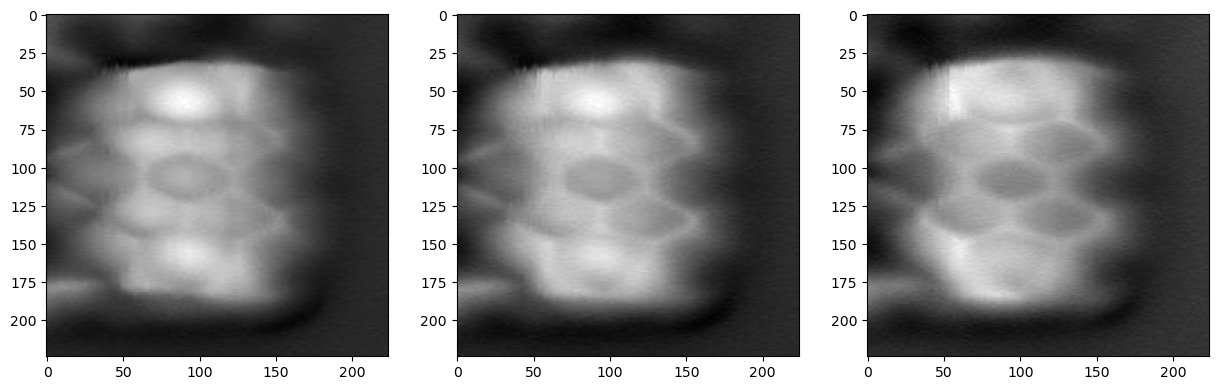

In [103]:
# 3 images

f, axarr = plt.subplots(1,3, figsize=(15, 5))
axarr[0].imshow(exp_img[0], cmap = 'gray')
axarr[1].imshow(exp_img[1], cmap = 'gray')
axarr[2].imshow(exp_img[2], cmap = 'gray')


In [104]:
#the CID was in neither train nor test so we added it, now it is here.

In [108]:

CID = 67191
SMILES = 'C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C(=O)OC7=O)C(=O)OC2=O'
morgan_fp = morgan_fp_gen(SMILES, nBits=1024)
split='test'
corrugation = np.nan



experimental_df = sample_df.append({'path':path,
                           'CID':CID, 
                           'SMILES':SMILES,
                           'morgan_fp':morgan_fp,
                           'split':split,
                           'corrugation':corrugation,
                           'C':24,
                           'Br':0,
                           'Cl':0,
                           'F':0,
                           'I':0,
                           'N':0,
                           'O':6,
                           'P':0,
                           'S':0,
                           'H':8,

                                    
                            }
                                   , ignore_index=True)
experimental_df

/tmp/ipykernel_128139/3478293630.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  experimental_df = sample_df.append({'path':path,


CID   C  Br  Cl  F  I  N  O  P  S   H split  \
0        10001048  25   0   0  0  0  6  0  0  0  16  test   
1           10005   2   0   0  0  0  4  0  0  0   4  test   
2       100128716  15   0   0  0  0  3  0  0  0  21  test   
3       100175925  10   0   0  0  0  3  4  0  2   9  test   
4       100197007  18   0   0  0  0  3  4  0  2  13  test   
...           ...  ..  ..  .. .. .. .. .. .. ..  ..   ...   
279844     341027  11   0   0  0  0  0  5  0  0   6  test   
279845   53921077   7   0   0  0  0  2  0  0  0   8  test   
279846   82382131  14   0   0  0  0  3  2  0  0  11  test   
279847   82418146   5   0   0  0  0  1  4  0  0   3  test   
279848      67191  24   0   0  0  0  0  6  0  0   8  test   

                                                     path  \
0       /scratch/dataset/quam/K-1/Conformer3D_CID_1000...   
1       /scratch/dataset/quam/K-1/Conformer3D_CID_1000...   
2       /scratch/dataset/quam/K-1/Conformer3D_CID_1001...   
3       /scratch/dataset/quam/K-1/Conformer3D_CID_1001...   
4       /scratch/dataset/quam/K-1/Conformer3D_CID_1001...   
...                                                   ...   
279844  /scratch/dataset/quam/K-1/Conformer3D_CID_3410...   
279845  /scratch/dataset/quam/K-1/Conformer3D_CID_5392...   
279846  /scratch/dataset/quam/K-1/Conformer3D_CID_8238...   
279847  /scratch/dataset/quam/K-1/Conformer3D_CID_8241...   
279848  /home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/Peryle...   

                                                   SMILES  corrugation  \
0                                                     NaN          NaN   
1                                                     NaN          NaN   
2                                                     NaN          NaN   
3                                                     NaN          NaN   
4                                                     NaN          NaN   
...                                                   ...          ...   
279844                                                NaN          NaN   
279845                                                NaN          NaN   
279846                                                NaN          NaN   
279847                                                NaN          NaN   
279848  C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C...          NaN   

                                                morgan_fp  
0                                                     NaN  
1                                                     NaN  
2                                                     NaN  
3                                                     NaN  
4                                                     NaN  
...                                                   ...  
279844                                                NaN  
279845                                                NaN  
279846                                                NaN  
279847                                                NaN  
279848  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  

[279849 rows x 16 columns]

In [109]:
experimental_df[experimental_df['path'] == path]

CID   C  Br  Cl  F  I  N  O  P  S  H split  \
279848  67191  24   0   0  0  0  0  6  0  0  8  test   

                                                     path  \
279848  /home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/Peryle...   

                                                   SMILES  corrugation  \
279848  C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C...          NaN   

                                                morgan_fp  
279848  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [111]:
exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=1)
with torch.no_grad():
    batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
    print(batched_tensor.size())
    predictions = model(batched_tensor)
    print(predictions.size())
    atom_count = torch.round(predictions) 
    print(atom_count.size())

atom_count = atom_count.cpu().numpy().astype(int).squeeze()
for atom, count in zip(['C', 'Br', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S', 'H'], atom_count):
    print(atom, ':', count)
print(f'Total atoms: {atom_count.sum()}')

torch.Size([1, 10, 224, 224])
torch.Size([10])
torch.Size([10])
C : 29
Br : 0
Cl : 0
F : 0
I : 0
N : 8
O : 4
P : 0
S : 0
H : 14
Total atoms: 55


In [116]:
gt_arr = np.array(experimental_df[experimental_df['path'] == path][['C','Br','Cl','F','I','N','O','P','S','H']]).squeeze()
gt_arr

array([24,  0,  0,  0,  0,  0,  6,  0,  0,  8])

In [115]:
def mae_loss(predictions, gt_arr):
    return np.sum(np.abs(predictions-gt_arr))
mae_loss(predictions, gt_arr)

13

In [114]:
for interpolation_method in ['bilinear', 'nearest', 'bicubic']:
    print(f'Interpolation method: {interpolation_method}')
    for zoom in [ 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]:
        exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=zoom, interpolation=interpolation_method)
        with torch.no_grad():
            batched_tensor = exp_img.unsqueeze(dim = 0).to(device)

            predictions = torch.round(model(batched_tensor))

            


        predictions = predictions.cpu().numpy().astype(int)

        
        
        print('zoom:', zoom, 'mae loss', mae_loss(predictions, gt_arr))


Interpolation method: bilinear
zoom: 0.5 mae loss 23
zoom: 0.6 mae loss 16
zoom: 0.7 mae loss 15
zoom: 0.8 mae loss 18
zoom: 0.9 mae loss 18
zoom: 1 mae loss 21
zoom: 1.1 mae loss 23
zoom: 1.2 mae loss 28
zoom: 1.3 mae loss 25
zoom: 1.4 mae loss 18
zoom: 1.5 mae loss 11
Interpolation method: nearest
zoom: 0.5 mae loss 23
zoom: 0.6 mae loss 15
zoom: 0.7 mae loss 14
zoom: 0.8 mae loss 17
zoom: 0.9 mae loss 17
zoom: 1 mae loss 18
zoom: 1.1 mae loss 26
zoom: 1.2 mae loss 29
zoom: 1.3 mae loss 28
zoom: 1.4 mae loss 19
zoom: 1.5 mae loss 15
Interpolation method: bicubic
zoom: 0.5 mae loss 23
zoom: 0.6 mae loss 16
zoom: 0.7 mae loss 15
zoom: 0.8 mae loss 17
zoom: 0.9 mae loss 18
zoom: 1 mae loss 21
zoom: 1.1 mae loss 24
zoom: 1.2 mae loss 26
zoom: 1.3 mae loss 23
zoom: 1.4 mae loss 13
zoom: 1.5 mae loss 13


### PTCDA Padded

In [128]:
path = '/home/mgonzalez/EXPERIMENTAL_IMAGES/PADDED/Perylenetetracarboxylic_dianhydride_PTCDA' 
sample_df = test_df
sorted(glob.glob(os.path.join(path,'*')))

['/home/mgonzalez/EXPERIMENTAL_IMAGES/PADDED/Perylenetetracarboxylic_dianhydride_PTCDA/image_0.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/PADDED/Perylenetetracarboxylic_dianhydride_PTCDA/image_1.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/PADDED/Perylenetetracarboxylic_dianhydride_PTCDA/image_2.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/PADDED/Perylenetetracarboxylic_dianhydride_PTCDA/image_3.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/PADDED/Perylenetetracarboxylic_dianhydride_PTCDA/image_4.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/PADDED/Perylenetetracarboxylic_dianhydride_PTCDA/image_5.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/PADDED/Perylenetetracarboxylic_dianhydride_PTCDA/image_6.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/PADDED/Perylenetetracarboxylic_dianhydride_PTCDA/image_7.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/PADDED/Perylenetetracarboxylic_dianhydride_PTCDA/image_8.jpg',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/PADDED/Perylenetetracarboxylic_dianhydride_PTCDA/imag

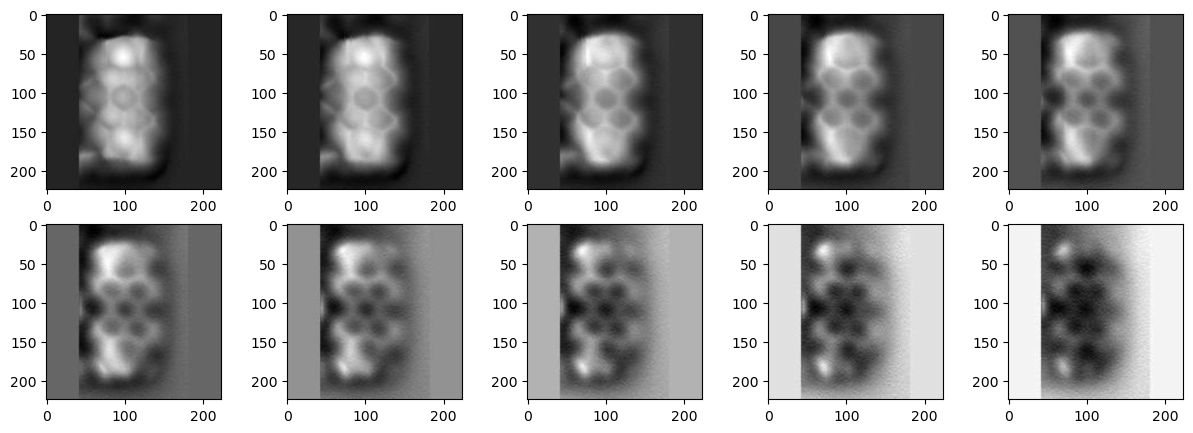

In [129]:
exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=1)
#10 images
f, axarr = plt.subplots(2,5, figsize=(15, 5))
axarr[0,0].imshow(exp_img[0], cmap = 'gray')
axarr[0,1].imshow(exp_img[1], cmap = 'gray')
axarr[0,2].imshow(exp_img[2], cmap = 'gray')
axarr[0,3].imshow(exp_img[3], cmap = 'gray')
axarr[0,4].imshow(exp_img[4], cmap = 'gray')
axarr[1,0].imshow(exp_img[5], cmap = 'gray')
axarr[1,1].imshow(exp_img[6], cmap = 'gray')
axarr[1,2].imshow(exp_img[7], cmap = 'gray')
axarr[1,3].imshow(exp_img[8], cmap = 'gray')
axarr[1,4].imshow(exp_img[9], cmap = 'gray')

In [130]:
sample_df

CID   C  Br  Cl  F  I  N  O  P  S   H split  \
1        10001048  25   0   0  0  0  6  0  0  0  16  test   
7           10005   2   0   0  0  0  4  0  0  0   4  test   
14      100128716  15   0   0  0  0  3  0  0  0  21  test   
15      100175925  10   0   0  0  0  3  4  0  2   9  test   
16      100197007  18   0   0  0  0  3  4  0  2  13  test   
...           ...  ..  ..  .. .. .. .. .. .. ..  ..   ...   
579897   13762891  16   0   0  0  0  2  6  0  0  12  test   
579900     341027  11   0   0  0  0  0  5  0  0   6  test   
579902   53921077   7   0   0  0  0  2  0  0  0   8  test   
579903   82382131  14   0   0  0  0  3  2  0  0  11  test   
579904   82418146   5   0   0  0  0  1  4  0  0   3  test   

                                                     path  
1       /scratch/dataset/quam/K-1/Conformer3D_CID_1000...  
7       /scratch/dataset/quam/K-1/Conformer3D_CID_1000...  
14      /scratch/dataset/quam/K-1/Conformer3D_CID_1001...  
15      /scratch/dataset/quam/K-1/Conformer3D_CID_1001...  
16      /scratch/dataset/quam/K-1/Conformer3D_CID_1001...  
...                                                   ...  
579897  /scratch/dataset/quam/K-1/Conformer3D_CID_1376...  
579900  /scratch/dataset/quam/K-1/Conformer3D_CID_3410...  
579902  /scratch/dataset/quam/K-1/Conformer3D_CID_5392...  
579903  /scratch/dataset/quam/K-1/Conformer3D_CID_8238...  
579904  /scratch/dataset/quam/K-1/Conformer3D_CID_8241...  

[279848 rows x 13 columns]

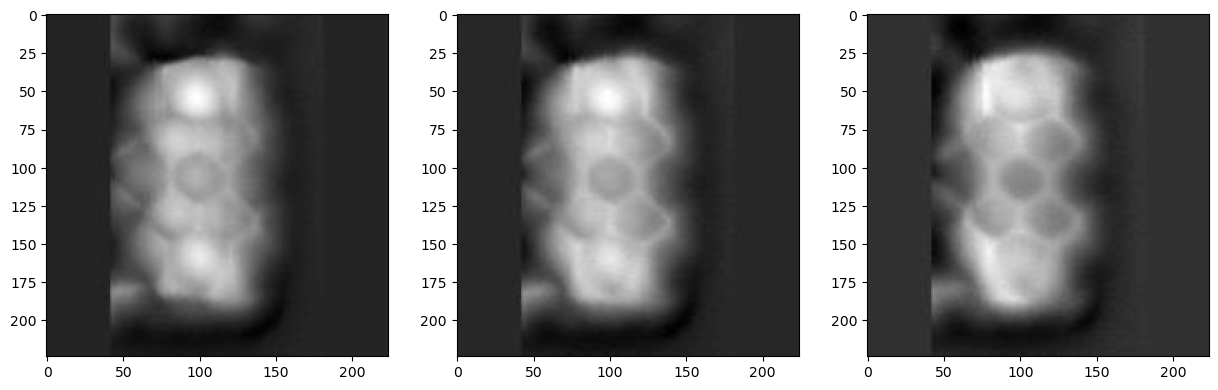

In [131]:
# 3 images

f, axarr = plt.subplots(1,3, figsize=(15, 5))
axarr[0].imshow(exp_img[0], cmap = 'gray')
axarr[1].imshow(exp_img[1], cmap = 'gray')
axarr[2].imshow(exp_img[2], cmap = 'gray')


In [132]:
#the CID was in neither train nor test so we added it, now it is here.

In [133]:

CID = 67191
SMILES = 'C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C(=O)OC7=O)C(=O)OC2=O'
morgan_fp = morgan_fp_gen(SMILES, nBits=1024)
split='test'
corrugation = np.nan



experimental_df = sample_df.append({'path':path,
                           'CID':CID, 
                           'SMILES':SMILES,
                           'morgan_fp':morgan_fp,
                           'split':split,
                           'corrugation':corrugation,
                           'C':24,
                           'Br':0,
                           'Cl':0,
                           'F':0,
                           'I':0,
                           'N':0,
                           'O':6,
                           'P':0,
                           'S':0,
                           'H':8,

                                    
                            }
                                   , ignore_index=True)
experimental_df

/tmp/ipykernel_128139/3478293630.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  experimental_df = sample_df.append({'path':path,


CID   C  Br  Cl  F  I  N  O  P  S   H split  \
0        10001048  25   0   0  0  0  6  0  0  0  16  test   
1           10005   2   0   0  0  0  4  0  0  0   4  test   
2       100128716  15   0   0  0  0  3  0  0  0  21  test   
3       100175925  10   0   0  0  0  3  4  0  2   9  test   
4       100197007  18   0   0  0  0  3  4  0  2  13  test   
...           ...  ..  ..  .. .. .. .. .. .. ..  ..   ...   
279844     341027  11   0   0  0  0  0  5  0  0   6  test   
279845   53921077   7   0   0  0  0  2  0  0  0   8  test   
279846   82382131  14   0   0  0  0  3  2  0  0  11  test   
279847   82418146   5   0   0  0  0  1  4  0  0   3  test   
279848      67191  24   0   0  0  0  0  6  0  0   8  test   

                                                     path  \
0       /scratch/dataset/quam/K-1/Conformer3D_CID_1000...   
1       /scratch/dataset/quam/K-1/Conformer3D_CID_1000...   
2       /scratch/dataset/quam/K-1/Conformer3D_CID_1001...   
3       /scratch/dataset/quam/K-1/Conformer3D_CID_1001...   
4       /scratch/dataset/quam/K-1/Conformer3D_CID_1001...   
...                                                   ...   
279844  /scratch/dataset/quam/K-1/Conformer3D_CID_3410...   
279845  /scratch/dataset/quam/K-1/Conformer3D_CID_5392...   
279846  /scratch/dataset/quam/K-1/Conformer3D_CID_8238...   
279847  /scratch/dataset/quam/K-1/Conformer3D_CID_8241...   
279848  /home/mgonzalez/EXPERIMENTAL_IMAGES/PADDED/Per...   

                                                   SMILES  corrugation  \
0                                                     NaN          NaN   
1                                                     NaN          NaN   
2                                                     NaN          NaN   
3                                                     NaN          NaN   
4                                                     NaN          NaN   
...                                                   ...          ...   
279844                                                NaN          NaN   
279845                                                NaN          NaN   
279846                                                NaN          NaN   
279847                                                NaN          NaN   
279848  C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C...          NaN   

                                                morgan_fp  
0                                                     NaN  
1                                                     NaN  
2                                                     NaN  
3                                                     NaN  
4                                                     NaN  
...                                                   ...  
279844                                                NaN  
279845                                                NaN  
279846                                                NaN  
279847                                                NaN  
279848  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  

[279849 rows x 16 columns]

In [134]:
experimental_df[experimental_df['path'] == path]

CID   C  Br  Cl  F  I  N  O  P  S  H split  \
279848  67191  24   0   0  0  0  0  6  0  0  8  test   

                                                     path  \
279848  /home/mgonzalez/EXPERIMENTAL_IMAGES/PADDED/Per...   

                                                   SMILES  corrugation  \
279848  C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C...          NaN   

                                                morgan_fp  
279848  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [135]:
exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=1)
with torch.no_grad():
    batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
    print(batched_tensor.size())
    predictions = model(batched_tensor)
    print(predictions.size())
    atom_count = torch.round(predictions) 
    print(atom_count.size())

atom_count = atom_count.cpu().numpy().astype(int).squeeze()
for atom, count in zip(['C', 'Br', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S', 'H'], atom_count):
    print(atom, ':', count)
print(f'Total atoms: {atom_count.sum()}')

torch.Size([1, 10, 224, 224])
torch.Size([10])
torch.Size([10])
C : 29
Br : 0
Cl : 0
F : 0
I : 0
N : 3
O : 3
P : 0
S : 0
H : 19
Total atoms: 54


In [136]:
gt_arr = np.array(experimental_df[experimental_df['path'] == path][['C','Br','Cl','F','I','N','O','P','S','H']]).squeeze()
gt_arr

array([24,  0,  0,  0,  0,  0,  6,  0,  0,  8])

In [137]:
def mae_loss(predictions, gt_arr):
    return np.sum(np.abs(predictions-gt_arr))
mae_loss(predictions, gt_arr)

TypeError: sum() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * (*, torch.dtype dtype)
      didn't match because some of the keywords were incorrect: out, axis
 * (tuple of ints dim, bool keepdim, *, torch.dtype dtype)
 * (tuple of names dim, bool keepdim, *, torch.dtype dtype)


In [138]:
for interpolation_method in ['bilinear', 'nearest', 'bicubic']:
    print(f'Interpolation method: {interpolation_method}')
    for zoom in [ 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]:
        exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=zoom, interpolation=interpolation_method)
        with torch.no_grad():
            batched_tensor = exp_img.unsqueeze(dim = 0).to(device)

            predictions = torch.round(model(batched_tensor))

            


        predictions = predictions.cpu().numpy().astype(int)

        
        
        print('zoom:', zoom, 'mae loss', mae_loss(predictions, gt_arr))


Interpolation method: bilinear
zoom: 0.5 mae loss 16
zoom: 0.6 mae loss 19
zoom: 0.7 mae loss 23
zoom: 0.8 mae loss 21
zoom: 0.9 mae loss 21
zoom: 1 mae loss 22
zoom: 1.1 mae loss 20
zoom: 1.2 mae loss 17
zoom: 1.3 mae loss 20
zoom: 1.4 mae loss 21
zoom: 1.5 mae loss 19
Interpolation method: nearest
zoom: 0.5 mae loss 15
zoom: 0.6 mae loss 21
zoom: 0.7 mae loss 23
zoom: 0.8 mae loss 21
zoom: 0.9 mae loss 21
zoom: 1 mae loss 22
zoom: 1.1 mae loss 22
zoom: 1.2 mae loss 16
zoom: 1.3 mae loss 18
zoom: 1.4 mae loss 20
zoom: 1.5 mae loss 22
Interpolation method: bicubic
zoom: 0.5 mae loss 17
zoom: 0.6 mae loss 21
zoom: 0.7 mae loss 24
zoom: 0.8 mae loss 20
zoom: 0.9 mae loss 22
zoom: 1 mae loss 22
zoom: 1.1 mae loss 20
zoom: 1.2 mae loss 18
zoom: 1.3 mae loss 21
zoom: 1.4 mae loss 21
zoom: 1.5 mae loss 18


### 2,7-Dibromopyrene

In [117]:
path = f'/home/{USER}/EXPERIMENTAL_IMAGES/RAW/2,7-Dibromopyrene-Cu111/image_stack/stack_further' 
sample_df = test_df
sorted(glob.glob(os.path.join(path,'*')))

['/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2,7-Dibromopyrene-Cu111/image_stack/stack_further/df_01_100pm DBP.png',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2,7-Dibromopyrene-Cu111/image_stack/stack_further/df_02_115pm DBP.png',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2,7-Dibromopyrene-Cu111/image_stack/stack_further/df_03_130pm DBP.png',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2,7-Dibromopyrene-Cu111/image_stack/stack_further/df_04_145pm DBP.png',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2,7-Dibromopyrene-Cu111/image_stack/stack_further/df_05_160pm DBP.png',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2,7-Dibromopyrene-Cu111/image_stack/stack_further/df_06_175pm DBP.png',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2,7-Dibromopyrene-Cu111/image_stack/stack_further/df_07_190pm DBP.png',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2,7-Dibromopyrene-Cu111/image_stack/stack_further/df_08_205pm DBP.png',
 '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2,7-Dibromopyrene-Cu111/image_stack/stack_furt

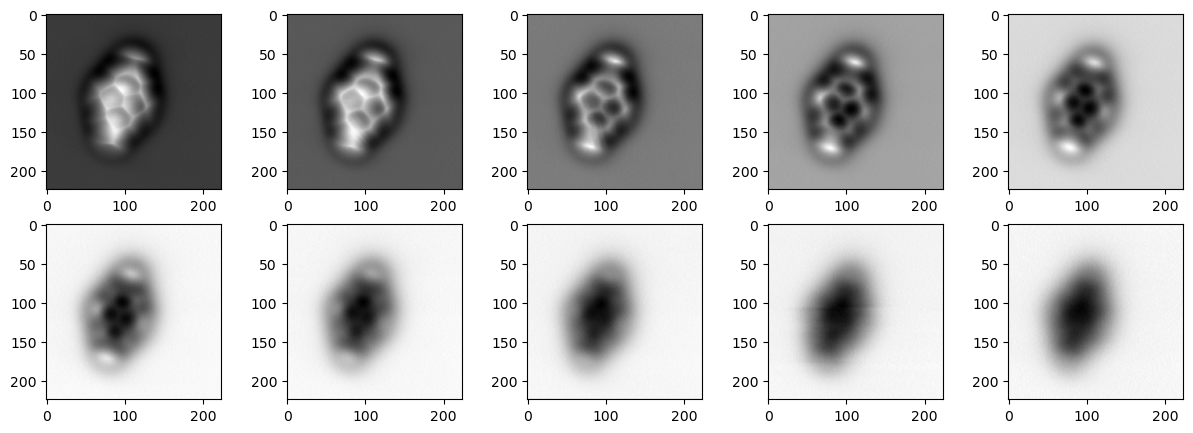

In [118]:
exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=1)
#10 images
f, axarr = plt.subplots(2,5, figsize=(15, 5))
axarr[0,0].imshow(exp_img[0], cmap = 'gray')
axarr[0,1].imshow(exp_img[1], cmap = 'gray')
axarr[0,2].imshow(exp_img[2], cmap = 'gray')
axarr[0,3].imshow(exp_img[3], cmap = 'gray')
axarr[0,4].imshow(exp_img[4], cmap = 'gray')
axarr[1,0].imshow(exp_img[5], cmap = 'gray')
axarr[1,1].imshow(exp_img[6], cmap = 'gray')
axarr[1,2].imshow(exp_img[7], cmap = 'gray')
axarr[1,3].imshow(exp_img[8], cmap = 'gray')
axarr[1,4].imshow(exp_img[9], cmap = 'gray')

In [119]:
sample_df

CID   C  Br  Cl  F  I  N  O  P  S   H split  \
1        10001048  25   0   0  0  0  6  0  0  0  16  test   
7           10005   2   0   0  0  0  4  0  0  0   4  test   
14      100128716  15   0   0  0  0  3  0  0  0  21  test   
15      100175925  10   0   0  0  0  3  4  0  2   9  test   
16      100197007  18   0   0  0  0  3  4  0  2  13  test   
...           ...  ..  ..  .. .. .. .. .. .. ..  ..   ...   
579897   13762891  16   0   0  0  0  2  6  0  0  12  test   
579900     341027  11   0   0  0  0  0  5  0  0   6  test   
579902   53921077   7   0   0  0  0  2  0  0  0   8  test   
579903   82382131  14   0   0  0  0  3  2  0  0  11  test   
579904   82418146   5   0   0  0  0  1  4  0  0   3  test   

                                                     path  
1       /scratch/dataset/quam/K-1/Conformer3D_CID_1000...  
7       /scratch/dataset/quam/K-1/Conformer3D_CID_1000...  
14      /scratch/dataset/quam/K-1/Conformer3D_CID_1001...  
15      /scratch/dataset/quam/K-1/Conformer3D_CID_1001...  
16      /scratch/dataset/quam/K-1/Conformer3D_CID_1001...  
...                                                   ...  
579897  /scratch/dataset/quam/K-1/Conformer3D_CID_1376...  
579900  /scratch/dataset/quam/K-1/Conformer3D_CID_3410...  
579902  /scratch/dataset/quam/K-1/Conformer3D_CID_5392...  
579903  /scratch/dataset/quam/K-1/Conformer3D_CID_8238...  
579904  /scratch/dataset/quam/K-1/Conformer3D_CID_8241...  

[279848 rows x 13 columns]

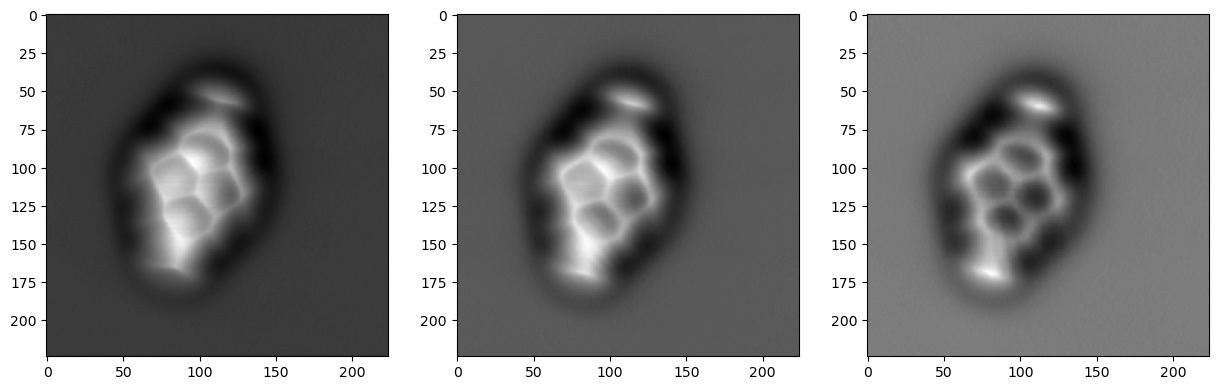

In [120]:
# 3 images

f, axarr = plt.subplots(1,3, figsize=(15, 5))
axarr[0].imshow(exp_img[0], cmap = 'gray')
axarr[1].imshow(exp_img[1], cmap = 'gray')
axarr[2].imshow(exp_img[2], cmap = 'gray')


In [121]:
#the CID was in neither train nor test so we added it, now it is here.

In [122]:

CID = 67191
SMILES = 'C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C(=O)OC7=O)C(=O)OC2=O'
morgan_fp = morgan_fp_gen(SMILES, nBits=1024)
split='test'
corrugation = np.nan



experimental_df = sample_df.append({'path':path,
                           'CID':CID, 
                           'SMILES':SMILES,
                           'morgan_fp':morgan_fp,
                           'split':split,
                           'corrugation':corrugation,
                           'C':16,
                           'Br':2,
                           'Cl':0,
                           'F':0,
                           'I':0,
                           'N':0,
                           'O':0,
                           'P':0,
                           'S':0,
                           'H':8,

                                    
                            }
                                   , ignore_index=True)
experimental_df

/tmp/ipykernel_128139/934508104.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  experimental_df = sample_df.append({'path':path,


CID   C  Br  Cl  F  I  N  O  P  S   H split  \
0        10001048  25   0   0  0  0  6  0  0  0  16  test   
1           10005   2   0   0  0  0  4  0  0  0   4  test   
2       100128716  15   0   0  0  0  3  0  0  0  21  test   
3       100175925  10   0   0  0  0  3  4  0  2   9  test   
4       100197007  18   0   0  0  0  3  4  0  2  13  test   
...           ...  ..  ..  .. .. .. .. .. .. ..  ..   ...   
279844     341027  11   0   0  0  0  0  5  0  0   6  test   
279845   53921077   7   0   0  0  0  2  0  0  0   8  test   
279846   82382131  14   0   0  0  0  3  2  0  0  11  test   
279847   82418146   5   0   0  0  0  1  4  0  0   3  test   
279848      67191  16   2   0  0  0  0  0  0  0   8  test   

                                                     path  \
0       /scratch/dataset/quam/K-1/Conformer3D_CID_1000...   
1       /scratch/dataset/quam/K-1/Conformer3D_CID_1000...   
2       /scratch/dataset/quam/K-1/Conformer3D_CID_1001...   
3       /scratch/dataset/quam/K-1/Conformer3D_CID_1001...   
4       /scratch/dataset/quam/K-1/Conformer3D_CID_1001...   
...                                                   ...   
279844  /scratch/dataset/quam/K-1/Conformer3D_CID_3410...   
279845  /scratch/dataset/quam/K-1/Conformer3D_CID_5392...   
279846  /scratch/dataset/quam/K-1/Conformer3D_CID_8238...   
279847  /scratch/dataset/quam/K-1/Conformer3D_CID_8241...   
279848  /home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2,7-Di...   

                                                   SMILES  corrugation  \
0                                                     NaN          NaN   
1                                                     NaN          NaN   
2                                                     NaN          NaN   
3                                                     NaN          NaN   
4                                                     NaN          NaN   
...                                                   ...          ...   
279844                                                NaN          NaN   
279845                                                NaN          NaN   
279846                                                NaN          NaN   
279847                                                NaN          NaN   
279848  C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C...          NaN   

                                                morgan_fp  
0                                                     NaN  
1                                                     NaN  
2                                                     NaN  
3                                                     NaN  
4                                                     NaN  
...                                                   ...  
279844                                                NaN  
279845                                                NaN  
279846                                                NaN  
279847                                                NaN  
279848  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  

[279849 rows x 16 columns]

In [123]:
experimental_df[experimental_df['path'] == path]

CID   C  Br  Cl  F  I  N  O  P  S  H split  \
279848  67191  16   2   0  0  0  0  0  0  0  8  test   

                                                     path  \
279848  /home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/2,7-Di...   

                                                   SMILES  corrugation  \
279848  C1=CC2=C3C(=CC=C4C3=C1C5=C6C4=CC=C7C6=C(C=C5)C...          NaN   

                                                morgan_fp  
279848  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [124]:
exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=1)
with torch.no_grad():
    batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
    print(batched_tensor.size())
    predictions = model(batched_tensor)
    print(predictions.size())
    atom_count = torch.round(predictions) 
    print(atom_count.size())

atom_count = atom_count.cpu().numpy().astype(int).squeeze()
for atom, count in zip(['C', 'Br', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S', 'H'], atom_count):
    print(atom, ':', count)
print(f'Total atoms: {atom_count.sum()}')

torch.Size([1, 10, 224, 224])
torch.Size([10])
torch.Size([10])
C : 14
Br : 2
Cl : 0
F : 0
I : 0
N : 1
O : 0
P : 0
S : 0
H : 7
Total atoms: 24


In [125]:
gt_arr = np.array(experimental_df[experimental_df['path'] == path][['C','Br','Cl','F','I','N','O','P','S','H']]).squeeze()
gt_arr

array([16,  2,  0,  0,  0,  0,  0,  0,  0,  8])

In [126]:
def mae_loss(predictions, gt_arr):
    return np.sum(np.abs(predictions-gt_arr))
mae_loss(predictions, gt_arr)

TypeError: sum() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * (*, torch.dtype dtype)
      didn't match because some of the keywords were incorrect: out, axis
 * (tuple of ints dim, bool keepdim, *, torch.dtype dtype)
 * (tuple of names dim, bool keepdim, *, torch.dtype dtype)


In [127]:
for interpolation_method in ['bilinear', 'nearest', 'bicubic']:
    print(f'Interpolation method: {interpolation_method}')
    for zoom in [ 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]:
        exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=zoom, interpolation=interpolation_method)
        with torch.no_grad():
            batched_tensor = exp_img.unsqueeze(dim = 0).to(device)

            predictions = torch.round(model(batched_tensor))

            


        predictions = predictions.cpu().numpy().astype(int)

        
        
        print('zoom:', zoom, 'mae loss', mae_loss(predictions, gt_arr))


Interpolation method: bilinear
zoom: 0.5 mae loss 25
zoom: 0.6 mae loss 26
zoom: 0.7 mae loss 16
zoom: 0.8 mae loss 7
zoom: 0.9 mae loss 4
zoom: 1 mae loss 4
zoom: 1.1 mae loss 3
zoom: 1.2 mae loss 2
zoom: 1.3 mae loss 2
zoom: 1.4 mae loss 4
zoom: 1.5 mae loss 3
Interpolation method: nearest
zoom: 0.5 mae loss 24
zoom: 0.6 mae loss 24
zoom: 0.7 mae loss 10
zoom: 0.8 mae loss 8
zoom: 0.9 mae loss 6
zoom: 1 mae loss 4
zoom: 1.1 mae loss 3
zoom: 1.2 mae loss 2
zoom: 1.3 mae loss 3
zoom: 1.4 mae loss 4
zoom: 1.5 mae loss 3
Interpolation method: bicubic
zoom: 0.5 mae loss 25
zoom: 0.6 mae loss 26
zoom: 0.7 mae loss 16
zoom: 0.8 mae loss 8
zoom: 0.9 mae loss 5
zoom: 1 mae loss 4
zoom: 1.1 mae loss 3
zoom: 1.2 mae loss 1
zoom: 1.3 mae loss 2
zoom: 1.4 mae loss 4
zoom: 1.5 mae loss 3
